# Imports and plot properties


In [1]:
import os
import glob
import timeit
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.ndimage import shift
from scipy.signal import find_peaks
from scipy import stats

import statsmodels.stats.api as sms
from statannot import add_stat_annotation

import matplotlib.pyplot as plt
import matplotlib as mlt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.collections import LineCollection
from matplotlib.font_manager import FontProperties
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from tempfile import TemporaryFile
from pathlib import Path

from Locomotion import *


#############################   Plot properties   ########################################################


font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_style('italic')
font.set_size('30')
font.set_weight('bold')

font_label = FontProperties()
font_label.set_family('serif')
font_label.set_name('Times New Roman')
font_label.set_style('italic')
font_label.set_size('25')
font_label.set_weight('bold')

# Constants

You must input some information regarding the experiment below:

In [2]:
video_height = 800
video_width = 1920
fps = 250; # frame per second 
left_edge_x = 115 # one end of treadmil in the image reported in pixels
right_edge_x = 1565 # pix
treadmill_len = 37.6 # cm
elec_shock = 3 # electro shock section of the treadmil cm
scale_pix_to_cm = treadmill_len/(right_edge_x-left_edge_x) # one pix in cm
treadmil_velocity = 15 # default treadmill velocity in cm/s
interval_in_sec = 0.5 # duration of stimulation in sec
pre_stim_interval = 0.25 # pre stimulus interval for looking at x ,v and acceleration
pre_stim_interval_measure = 0.5 # pre stimulus interval for the laser-OFF epoch in seconds
post_stim_interval_measure = 0.5 # post stimulus interval for the laser-OFF epoch in seconds

n_timebin = 30 # number of frames for calculating velocity 
window_pos = 10 # moving average window for position smoothing
window_veloc = 5 # moving average window for velocity smoothing
max_speed = 28 # (cm/s) the max speed of the mouse derived from recovety of FoxP2 form laser trial

mouse_dict = {'D2' : {'ChR2': [156, 165, 166, 195, 196, 198, 199],
                      'Control': [172, 178]}, 
              'Vglut2': {'ChR2':[116, 117, 118, 119, 164, 165, 166],
                         'Control':  [359, 360]}, 
              'FoxP2': {'ChR2':[8, 9, 10, 11, 24, 27],
                        'Control': [23, 26]},
              'Vglut2D2': {'ChR2': [55, 57, 58, 59, 60, 70, 71], 
                           'Control':[63, 73]}
             }
mouse_types = list(mouse_dict.keys())
pre_direct = '/home/shiva/Desktop/Shiva_Behavior/' # ubuntu directory
pre_direct = '/media/shiva/LaCie/Data_INCIA_Shiva_sorted' # ubuntu directory


Run the cell below to infer other constants from the ones you input above

In [3]:
min_t_between_stim = 1 * fps, #s minimum time between stimulations (used to distinguish beta stimulations)

accep_interval_range = (int((121.5/125) * interval_in_sec * fps), 
                        int((128/125) * interval_in_sec * fps)) # criteria for discarding the detected laser epochs

t_window_dict = {'fps' : fps, 
                 'n_timebin' : n_timebin, 
                 'window_pos' : window_pos, 
                 'window_veloc' : window_veloc}

exp_dict = {'cor_list' : np.array(['x', 'y']),
            'body_part_list' : np.array(['Tail', 'Nose', 'FL', 'HL']),
            'plot_param_list' : ['position' , 'velocity', 'acceleration']
           }

spont_trial_dict = {'max_distance' : int( 4.5 * fps), # max #n_timebines between sampled epochs for spontaneous
                     'min_distance' : int( 3 * fps), # min #n_timebines between sampled epochs for spontaneous
                     'n_trials_spont' : 25 # the average number of trials extracted from one spontaneous session
                    }

intervals_dict = {'pre_interval' : int(pre_stim_interval_measure*fps), # interval before laser onset
                  'interval' : int(interval_in_sec * fps), # number of timebins of stimulation
                  'post_interval' : int(post_stim_interval_measure*fps*2), # interval after laser onset
                   'pre_stim_inter' : int(pre_stim_interval*fps) }


pre_x_v_dict = {'back_front_boundary' : (treadmill_len-elec_shock)/2, # set the limit below which is considered back of the treadmill
                'v_threshold' : 0,
                'pre_stim_inter' : int(pre_stim_interval*fps) # number of timebins in the pre-stimulus period 
                 }


misdetection_dict = { 'acc_deviance' : 1.5, # cm = acceptable deviance between right and left detections
                      'internal_ctr_dev' : 0.5,
                      'percent_thresh_align' : 0.8,
                      't_s' : 30, # number of time steps before and after to look at
                      'n_iter_jitter' : 1, # how many times go over data to find jitters and clear them out
                      'jitter_threshold' : max_speed / fps,
                    }


### Determine the protocols for each mouse line and their corresponding colormaps

In [4]:
c_spont = 'k'         

top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0.3, 1, 128)),
                       bottom(np.linspace(0.3, 1, 128))))
beta_cm = ListedColormap(newcolors, name='OrangeBlue')


top = cm.get_cmap('Reds_r', 128)
bottom = cm.get_cmap('Greens', 128)

newcolors = np.vstack((top(np.linspace(0.3, 1, 128)),
                       bottom(np.linspace(0.3, 1, 128))))
square_cm = ListedColormap(newcolors, name='RedGreen')


pulse_cmap_dict = {'single_stim': {'betapulse' : beta_cm, 
                                   'squarepulse': square_cm},
                   
                   'double_stim': {'betapulse' : 'cividis', 
                                   'squarepulse': 'winter',
                                   'betapulse-squarepulse': 'Wistia'}}

protocol_dict = {
    'D2' : {'STR': {
                    'squarepulse': 
                        ['squarepulse_0-5_mW',
                         'squarepulse_1_mW'],
                    'betapulse': 
                        ['betapulse_0-5_mW',
                          'betapulse_1_mW']}},#,
                         # 'betapulse_5_mW']}},
        
    'Vglut2': {'STN': {
                    'squarepulse': 
                        ['squarepulse_0-5_mW',
                         'squarepulse_1_mW'],
                    'betapulse': 
                        ['betapulse_0-5_mW',
                         'betapulse_1_mW']},
               'GPe': {
                    'squarepulse': 
                        ['squarepulse_15_mW'],
                    'betapulse': []},
               'STN-GPe': {
                   'squarepulse': 
                       ['squarepulse_1-15_mW'],
                    'betapulse': []}},
    
    'FoxP2': {'GPe': {
                    'squarepulse': 
                        ['squarepulse_0-25_mW',
                         'squarepulse_0-5_mW',
                         'squarepulse_1_mW'],
                    'betapulse': 
                        ['betapulse_0-5_mW',
                         'betapulse_1_mW',
                         'betapulse_2_mW',
                         'betapulse_5_mW']}},
        
    'Vglut2D2': {'STN': {
                    'squarepulse': 
                        ['squarepulse_0-5_mW',
                         'squarepulse_0-75_mW'],
                     'betapulse': []},
                'STR': { 
                    'squarepulse': 
                        ['squarepulse_0-35_mW',
                         'squarepulse_0-5_mW',
                         'squarepulse_1_mW'],
                    'betapulse': 
                        ['betapulse_0-5_mW',
                         'betapulse_0-75_mW',
                         'betapulse_1_mW',
                         'betapulse_2-5_mW']},

                 'STR-STN': {
                       'squarepulse': 
                           ['squarepulse_0-5_mW',
                            'squarepulse_0-35-0-5_mW'],
                       'betapulse': 
                           ['betapulse_0-75_mW',
                            'betapulse_5_mW'],
                       'betapulse-squarepulse': 
                           ['betapulse-squarepulse_5-0-75_mW']}}}

# Run one intensity and save data (all mice and types)

Specify one experiment protocol and intensity by folder together with the coordinate (x,y) and measure (position,velocity). This cell will extract the pre-on-post laser epochs of all mice and will save it together with the same number of spontaneous trials.
The file will contain 3 matrices:
    1. epochs of laser trials.  *size = (number of trials,pre-on-post duration)*
    2. epochs of spontaneous trials. *size = same as above*
    3. mean value for the measurement (x-pos or V) for the three epochs (pre,on,post) for each animal laser. *size = ( number of animals, 3)*

Type :  Vglut2D2 #  55
no Spont####################################################3

 session 1 out of 1
Looking at --- Tail ---
# inconsistent right left =  0
# jitter in mean(righ,left)  =  669
Looking at --- Nose ---
# inconsistent right left =  396
# jitter in mean(righ,left)  =  759
DLC: Vglut2D2Cre#55_betapulse_STR_5mW_15cm-s_s01_Stacked_DLC_resnet_50_treadmillOptoJun3shuffle1_1030000
Laser: Vglut2D2Cre#55_betapulse_STR_5mW_15cm-s_s01_Stacked_DLC_resnet_50_treadmillOptoJun3shuffle1_1030000_Laser
0  trials discarded
25 laser trials


/home/shiva/anaconda3/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:228: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)


runtime =  0  s
Type :  Vglut2D2 #  57
no Spont####################################################3
No DLC files for mouse # 57
Type :  Vglut2D2 #  58
no Spont####################################################3

 session 1 out of 2
Looking at --- Tail ---
There's a shift between left and right detections. Don't worry we will fix it!
# inconsistent right left =  30444
# jitter in mean(righ,left)  =  1539
Looking at --- Nose ---
There's a shift between left and right detections. Don't worry we will fix it!
# inconsistent right left =  30825
# jitter in mean(righ,left)  =  1457
DLC: Vglut2D2Cre#58_betapulse_STR_5mW_15cm-s_r15_Stacked_DLC_resnet_50_treadmillOptoJun3shuffle1_1030000
Laser: Vglut2D2Cre#58_betapulse_STR_5mW_15cm-s_r15_Stacked_DLC_resnet_50_treadmillOptoJun3shuffle1_1030000_Laser
0  trials discarded

 session 2 out of 2
Looking at --- Tail ---
# inconsistent right left =  0
# jitter in mean(righ,left)  =  74
Looking at --- Nose ---
# inconsistent right left =  0
# jitter in

/home/shiva/anaconda3/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:228: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)


runtime =  2  s
Type :  Vglut2D2 #  59
no Spont####################################################3

 session 1 out of 2
Looking at --- Tail ---
There's a shift between left and right detections. Don't worry we will fix it!
# inconsistent right left =  30566
# jitter in mean(righ,left)  =  1766
Looking at --- Nose ---
There's a shift between left and right detections. Don't worry we will fix it!
# inconsistent right left =  30574
# jitter in mean(righ,left)  =  1471
DLC: Vglut2D2Cre#59_betapulse_STR_5mW_15cm-s_r17_Stacked_DLC_resnet_50_treadmillOptoJun3shuffle1_1030000
Laser: Vglut2D2Cre#59_betapulse_STR_5mW_15cm-s_r17_Stacked_DLC_resnet_50_treadmillOptoJun3shuffle1_1030000_Laser
0  trials discarded

 session 2 out of 2
Looking at --- Tail ---
# inconsistent right left =  0
# jitter in mean(righ,left)  =  204
Looking at --- Nose ---
There's a shift between left and right detections. Don't worry we will fix it!
# inconsistent right left =  15652
# jitter in mean(righ,left)  =  1686
DLC

/home/shiva/anaconda3/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:228: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)


Looking at --- Tail ---
# inconsistent right left =  0
# jitter in mean(righ,left)  =  55
Looking at --- Nose ---
# inconsistent right left =  1163
# jitter in mean(righ,left)  =  171
DLC: Vglut2D2Cre#70_betapulse_STR_5mW_12cm-s_s09_Stacked_DLC_resnet_50_treadmillOptoJun3shuffle1_1030000
Laser: Vglut2D2Cre#70_betapulse_STR_5mW_12cm-s_s09_Stacked_DLC_resnet_50_treadmillOptoJun3shuffle1_1030000_Laser
0  trials discarded
18 laser trials
runtime =  0  s
Type :  Vglut2D2 #  71
no Spont####################################################3

 session 1 out of 2


/home/shiva/anaconda3/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:228: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)


Looking at --- Tail ---
# inconsistent right left =  0
# jitter in mean(righ,left)  =  202
Looking at --- Nose ---
# inconsistent right left =  1079
# jitter in mean(righ,left)  =  418
DLC: Vglut2D2Cre#71_betapulse_STR_5mW_12cm-s_s07_Stacked_DLC_resnet_50_treadmillOptoJun3shuffle1_1030000
Laser: Vglut2D2Cre#71_betapulse_STR_5mW_12cm-s_s07_Stacked_DLC_resnet_50_treadmillOptoJun3shuffle1_1030000_Laser
0  trials discarded

 session 2 out of 2
Looking at --- Tail ---
# inconsistent right left =  0
# jitter in mean(righ,left)  =  213
Looking at --- Nose ---
# inconsistent right left =  0
# jitter in mean(righ,left)  =  198
DLC: Vglut2D2Cre#71_betapulse_STR_5mW_15cm-s_t07_Stacked_DLC_resnet_50_treadmillOptoJun3shuffle1_1030000
Laser: Vglut2D2Cre#71_betapulse_STR_5mW_15cm-s_t07_Stacked_DLC_resnet_50_treadmillOptoJun3shuffle1_1030000_Laser
0  trials discarded
52 laser trials
runtime =  0  s


/home/shiva/anaconda3/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:228: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)


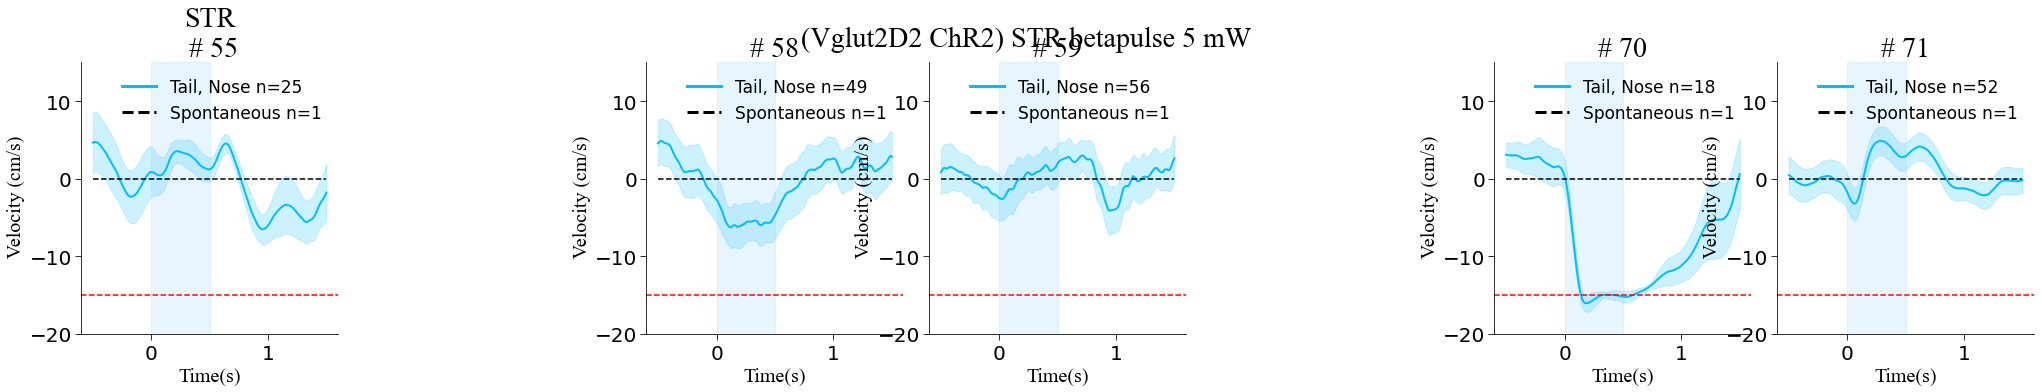

In [4]:

# study_param_dict = get_input_cor_body_part(**exp_dict) # decide to average over what and which coordinates
study_param_dict = {
                    'cor': 'x', 
                    'body_part': ['Tail', 'Nose'], 
                    'plot_param': 'velocity'
                    }
opto_par_list=['ChR2','Control']
opto_par_list=['ChR2']

mouse_t_list = list( mouse_dict.keys()) # mouse lines are the keys of the mouse dict
mouse_t_list = ['Vglut2D2']
ylim = [-20,15]

stim_type = 'squarepulse_0-25_mW'
stim_type = 'squarepulse_0-35mW'
stim_type = 'squarepulse_0-5_mW'
stim_type = 'squarepulse_1_mW'
stim_type = 'betapulse_0-5_mW'
stim_type = 'betapulse_1_mW'
stim_type = 'betapulse_2_mW'
stim_type = 'betapulse_5_mW'

stim_loc = 'STR-STN'
stim_loc = 'STN'
stim_loc = 'STR'

for mouse_type in mouse_t_list:  
    
    for opto_par in opto_par_list:
        
        run_one_intensity_save_data(pre_direct,
                                    scale_pix_to_cm,
                                    mouse_type, 
                                    mouse_dict[mouse_type],
                                    stim_loc,
                                    stim_type,
                                    opto_par,
                                    treadmill_velocity,
                                    ylim,
                                    spont_trial_dict,
                                    misdetection_dict,
                                    intervals_dict,
                                    t_window_dict,
                                    accep_interval_range,
                                    study_param_dict,
                                    **spont_trial_dict)


# Superimose all intensities for different locations and stim protocols

In [8]:
study_param_dict = {
                    'cor': 'x', 
                    'body_part': ['Tail', 'Nose'], 
                    'plot_param': 'velocity'
                    }
ylim = [-.5, 2]
x_label_list = [0, 0.5, 1, 1.5]
y_label_list = [-0.5, 0, 0.5, 1, 1.5, 2]
plot_spont = True
plot_spont = False


 

# mouse_type = 'FoxP2'
# ylim = [-30, 20]
# stim_loc_dict = {'ChR2':{'squarepulse': list(protocol_dict[mouse_type].keys()),
#                          'betapulse':  list(protocol_dict[mouse_type].keys())},
                 
#                    'Control': {'squarepulse':list(protocol_dict[mouse_type].keys()),
#                                 'betapulse': list(protocol_dict[mouse_type].keys())}}
# mouse_type = 'D2'
# stim_loc_dict = {'ChR2':{'squarepulse': list(protocol_dict[mouse_type].keys()),
#                          'betapulse':  list(protocol_dict[mouse_type].keys())},
                 
#                    'Control': {'squarepulse':list(protocol_dict[mouse_type].keys()),
#                                 'betapulse': list(protocol_dict[mouse_type].keys())}}

mouse_type = 'Vglut2'

stim_loc_dict = {'ChR2':{'squarepulse': list(protocol_dict[mouse_type].keys()),
                          'betapulse':  ['STN']},
                 
                    'Control': {'squarepulse': ['STN'],
                                'betapulse':  ['STN']}}

mouse_type = 'Vglut2D2'
plot_spont = False
stim_loc_dict = {'ChR2':{'squarepulse': list(protocol_dict[mouse_type].keys()),
                          'betapulse':   ['STR'],
                          'betapulse-squarepulse':  ['STR-STN']
                                            },
                  'Control': { 'squarepulse':  list(protocol_dict[mouse_type].keys()),
                              'betapulse': ['STR'],
          }}



stim_type_dict = create_stim_type_dict(protocol_dict, list(protocol_dict[mouse_type].keys()), mouse_type)


cmap_dict = create_pulse_specific_color_lists(pulse_cmap_dict, stim_type_dict)
opto_par_list  = ['ChR2']
# opto_par_list  = ['Control']
suptitle_y  = {'Control': 1.1,
               'ChR2': 0.94}
figs = superimpose_intensities(opto_par_list, cmap_dict, stim_type_dict, stim_loc_dict, 
                        pre_direct, scale_pix_to_cm, mouse_type, mouse_dict[mouse_type], treadmil_velocity,
                        ylim, spont_trial_dict, misdetection_dict, intervals_dict, t_window_dict, accep_interval_range, 
                        study_param_dict, **spont_trial_dict, suptitle_y = suptitle_y , plot_spont = plot_spont,
                        x_label_list = x_label_list, y_label_list = y_label_list)#, ylabel_x = 0.2, xlabel_y = 0.2)



NameError: name 'create_pulse_specific_color_lists' is not defined

# Plots (pre | laser-ON | post)

## Average position or velocity (all the ChR2 mice)

### One intensity
Compare the average of all mice of each mouse type and compare with the equal number of spontaneous trials for one experiment protocol and intensity.

/home/shiva/Behavioral-Analysis/Locomotion/Locomotion.py:1605: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(x_formatter)
/home/shiva/Behavioral-Analysis/Locomotion/Locomotion.py:1580: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_major_formatter(y_formatter)


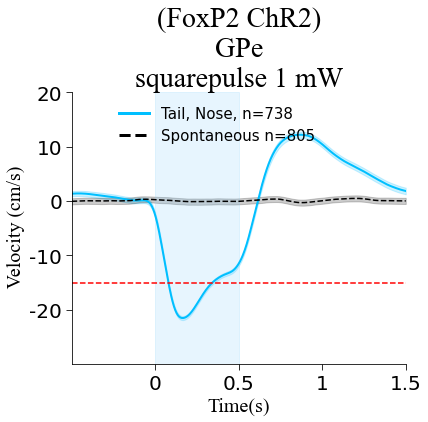

In [6]:
stim_type = 'squarepulse_1_mW'
stim_loc = 'GPe'
opto_par = 'ChR2'
# opto_par = 'Control'

path = os.path.join(pre_direct,'data_npz', stim_loc, stim_type, opto_par)
summary_files_list = list_all_files(path,".npz")
min_y_pre_post = -30 ; max_y_pre_post =  20

for count, filename in enumerate(summary_files_list):

    dat = np.load(os.path.join(path,filename))
    properties = filename.split("_")
    stim_type = '_'.join(filename.split("_")[3:6])
    mouse_type = properties[0]
    opto_par = properties[1]
    epochs_all_mice = dat['epochs_all_mice']
    epochs_spont_all_mice = dat['epochs_spont_all_mice']
#     epochs_spont_all_mice = np.zeros((epochs_all_mice.shape))
    study_param_dict = {'cor' : dat['cor'][0],
                        'body_part' : dat['body_part'], 
                        'plot_param' : dat['plot_param'][0]}


    plot_pre_on_post(pre_direct,mouse_type, opto_par, stim_loc, stim_type, 
                     epochs_all_mice, epochs_spont_all_mice,treadmill_velocity,
                     [min_y_pre_post, max_y_pre_post],
                     **t_window_dict,**study_param_dict,**intervals_dict,
                     average = 'Averg_trials_all_mice',
                     save_as_format = '.pdf')



### save summary to csv

In [4]:
stim_type = 'squarepulse_1_mW'
stim_loc_list = ['GPe', 'STR', 'STN']
opto_par = 'ChR2'


save_data_summary_to_excel(mouse_dict, pre_direct, stim_loc_list, 
                            stim_type, opto_par, intervals_dict, t_window_dict)

save_data_summary_all_ctrls_concatenated(stim_loc_list, pre_direct, stim_type, 
                                             intervals_dict, t_window_dict, opto_par = 'Control')

FoxP2 GPe  n_trials: 738
D2 STR  n_trials: 759
Vglut2D2 STR  n_trials: 97
Vglut2D2 STN  n_trials: 78
Vglut2 STN  n_trials: 793
dataframe is saved at:
 /media/shiva/LaCie/Data_INCIA_Shiva_sorted/data_npz/squarepulse_1_mW_ChR2.xlsx
dataframe is saved at:
 /media/shiva/LaCie/Data_INCIA_Shiva_sorted/data_npz/squarepulse_1_mW_Control.xlsx


### All intensities
To see the results of all different intensities in the same plot, determine the `opto_par`, `mouse_type`, and `stim_loc`. Since there are double-Cre animal data summaries in the same path, make sure you fill in `not_contains` to exclude unwanted files.

FoxP2
FoxP2


/home/shiva/Behavioral-Analysis/Locomotion/Locomotion.py:1605: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(x_formatter)
/home/shiva/Behavioral-Analysis/Locomotion/Locomotion.py:1580: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_major_formatter(y_formatter)


FoxP2
FoxP2


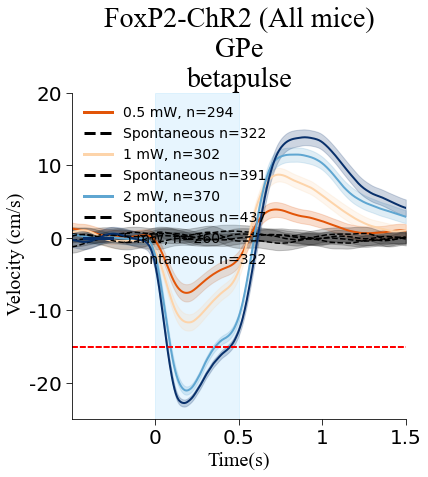

In [5]:
plt.close('all')
opto_par = 'ChR2'
label = 'intensity'

mouse_type = 'Vglut2D2'
stim_loc = 'STN'
stim_loc = 'STR'

# stim_loc = 'STR-STN'
# label = 'protocol'
not_contains = []
ylim = [0, 2]
x_label_list = [0, 0.5, 1, 1.5]
y_label_list = [-0.5, 0, 0.5, 1, 1.5, 2]

# mouse_type = 'FoxP2'
# stim_loc = 'GPe'
# min_y_pre_post = -25 ; max_y_pre_post =  20
# not_contains = []

# mouse_type = 'Vglut2'
# not_contains = ['D2']
# stim_loc = 'STN'
# min_y_pre_post = -15 ; max_y_pre_post =  10


# mouse_type = 'D2'
# not_contains = ['Vglut']
# stim_loc = 'STR'
# min_y_pre_post = -15 ; max_y_pre_post =  20



stim_type = 'squarepulse'
stim_type = 'betapulse'
        
path = os.path.join(pre_direct, 'data_npz', stim_loc)
files_list = find_files_containing_substring(path, ".npz")
summary_files_list = filter_based_on_substring(files_list, [stim_type, mouse_type, opto_par], not_contains = not_contains)


colors = choose_n_from_colormap(plt.get_cmap(pulse_cmap_dict['single_stim'][stim_type]), 
                                minval=0.0, maxval=1.0, n_colors = len(summary_files_list))
summary_files_list.sort()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), sharey=True)
axvspan = True

for count, filepath in enumerate(summary_files_list):

    data = np.load(filepath)
    info = extract_info_from_npz_filename(os.path.basename(filepath))
    study_param_dict = {'cor' : data['cor'][0],
                        'body_part' : data['body_part'], 
                        'plot_param' : data['plot_param'][0]}
    print(info['mouse_type'])
    
    if count > 0:
        axvspan = False
    
    ax, figname = plot_pre_on_post(pre_direct, 
                                   info['mouse_type'], info['opto_par'], 
                                   info['stim_loc'], info['stim_type'], 
                                   data['epochs_all_mice'], data['epochs_spont_all_mice'], 
                                   treadmil_velocity,
                                   ylim,
                                   **t_window_dict,**study_param_dict,**intervals_dict,
                                   average = 'all_mice', save_fig = False,
                                   label = label, axvspan = axvspan,
                                   c_laser = colors[count], c_spont = c_spont,
                                   save_as_format = '.pdf', ax = ax,
                                   legend_fontsize = 14,
                                   legend_loc = 'upper left',
                                   bbox_to_anch_leg=(0., 1.),
                                   x_label_list = x_label_list, 
                                   y_label_list = y_label_list)

Directory.create_dir_if_not_exist(os.path.join(pre_direct, 'Subplots', stim_loc))
filepath = os.path.join(pre_direct, 'Subplots', 
                        stim_loc, stim_type + '_' + figname)
save_pdf_png(fig, filepath.split('.')[0], size = (6, 6))

## Average position or velocity (all the control mice)
This cell will add the epochs of all the files in the chosen directory regardless of the mouse type. If you need the control data for one specific mouse type, remove the other files in the direcroty.

/home/shiva/Behavioral-Analysis/Locomotion/Locomotion.py:1605: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(x_formatter)
/home/shiva/Behavioral-Analysis/Locomotion/Locomotion.py:1580: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_major_formatter(y_formatter)


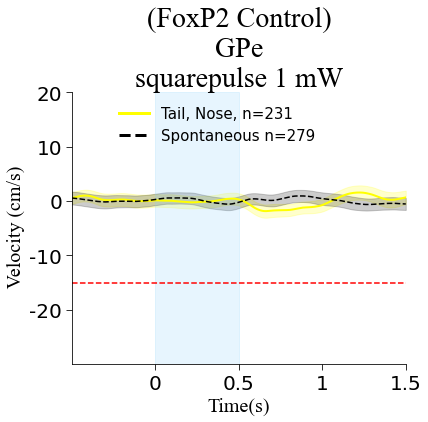

In [7]:
plt.close('all')
opto_par = 'Control'
label = 'intensity'

mouse_type = 'Vglut2D2'
stim_loc = 'STN'
stim_loc = 'STR'

# stim_loc = 'STR-STN'
# label = 'protocol'
not_contains = []
ylim = [0, 2]
x_label_list = [0, 0.5, 1, 1.5]
y_label_list = [-0.5, 0, 0.5, 1, 1.5, 2]

# mouse_type = 'FoxP2'
# stim_loc = 'GPe'
# min_y_pre_post = -25 ; max_y_pre_post =  20
# not_contains = []

# mouse_type = 'Vglut2'
# not_contains = ['D2']
# stim_loc = 'STN'
# min_y_pre_post = -15 ; max_y_pre_post =  10


# mouse_type = 'D2'
# not_contains = ['Vglut']
# stim_loc = 'STR'
# min_y_pre_post = -15 ; max_y_pre_post =  20



stim_type = 'squarepulse'
stim_type = 'betapulse'
        
path = os.path.join(pre_direct, 'data_npz', stim_loc)
files_list = find_files_containing_substring(path, ".npz")
summary_files_list = filter_based_on_substring(files_list, [stim_type, mouse_type, opto_par], not_contains = not_contains)


colors = choose_n_from_colormap(plt.get_cmap(pulse_cmap_dict['single_stim'][stim_type]), 
                                minval=0.0, maxval=1.0, n_colors = len(summary_files_list))
summary_files_list.sort()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), sharey=True)
axvspan = True

for count, filepath in enumerate(summary_files_list):

    data = np.load(filepath)
    info = extract_info_from_npz_filename(os.path.basename(filepath))
    study_param_dict = {'cor' : data['cor'][0],
                        'body_part' : data['body_part'], 
                        'plot_param' : data['plot_param'][0]}
    print(info['mouse_type'])
    
    if count > 0:
        axvspan = False
    
    ax, figname = plot_pre_on_post(pre_direct, 
                                   info['mouse_type'], info['opto_par'], 
                                   info['stim_loc'], info['stim_type'], 
                                   data['epochs_all_mice'], data['epochs_spont_all_mice'], 
                                   treadmil_velocity,
                                   ylim,
                                   **t_window_dict,**study_param_dict,**intervals_dict,
                                   average = 'all_mice', save_fig = False,
                                   label = label, axvspan = axvspan,
                                   c_laser = colors[count], c_spont = c_spont,
                                   save_as_format = '.pdf', ax = ax,
                                   legend_fontsize = 14,
                                   legend_loc = 'upper left',
                                   bbox_to_anch_leg=(0., 1.),
                                   x_label_list = x_label_list, 
                                   y_label_list = y_label_list)

Directory.create_dir_if_not_exist(os.path.join(pre_direct, 'Subplots', stim_loc))
filepath = os.path.join(pre_direct, 'Subplots', 
                        stim_loc, stim_type + '_' + figname)
save_pdf_png(fig, filepath.split('.')[0], size = (6, 6))

### save concatenated control mice summary to csv

In [12]:
stim_type = 'squarepulse_1_mW'
stim_loc_list = ['GPe', 'STR', 'STN']
opto_par = 'Control'

save_data_summary_all_ctrls_concatenated(stim_loc_list, pre_direct, stim_type, opto_par, 
                                         intervals_dict, t_window_dict)



120
D2_Control_Square_1_mW_mov_aver=40_n_t=120_x_velocity_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice', 'avg_pre_stim_position', 'avg_pre_stim_velocity', 'avg_pre_stim_acc', 'cor', 'body_part', 'plot_param']
(158,)
FoxP2_Control_Square_1_mW_mov_aver=40_n_t=120_x_velocity_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice', 'avg_pre_stim_position', 'avg_pre_stim_velocity', 'avg_pre_stim_acc', 'cor', 'body_part', 'plot_param']
(158,)
Vglut2_Control_Square_1_mW_mov_aver=40_n_t=120_x_velocity_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice', 'avg_pre_stim_position', 'avg_pre_stim_velocity', 'avg_pre_stim_acc', 'cor', 'body_part', 'plot_param']
(158,)


## Look at the relative distance between Limb and Tail in one epoch

Here we want to see the relative displacement of the back limb relative to the tail. (a constant value confirms freezing behavior)
set the values for the first five lines:

0  trials discarded
0  trials discarded


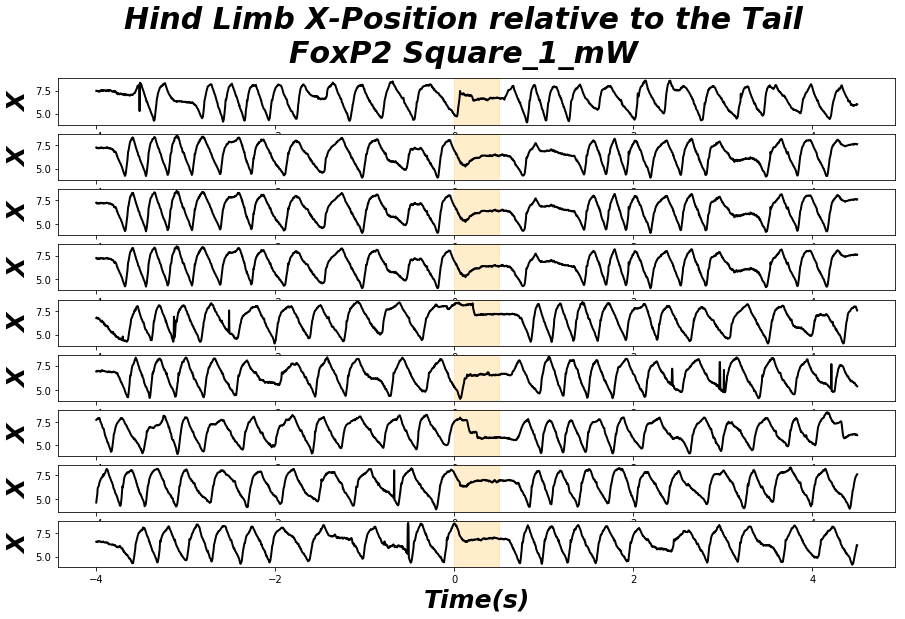

In [29]:
i = 4 # number of session
mouse_type = 'FoxP2' ; opto_par = 'ChR2' ; mouse_no = 8
folder ='Square_1_mW'
direct = os.path.join(pre_direct,mouse_type,opto_par,'Mouse_' + str(mouse_no)) # directory to the folder for each mouse
n =10 # number of trials to look at

files_list_DLC = list_all_files(os.path.join(direct,folder,'DLC'),".xlsx")
files_list_Laser = list_all_files(os.path.join(direct,folder,'Laser'),".xlsx")

file_name_pos = os.path.join(direct,folder,'DLC',files_list_DLC[i])
file_name_laser = os.path.join(direct,folder,'Laser',files_list_Laser[i])

between_stim = 250
df = read_DLC(file_name_pos,scale_pix_to_cm)
laser_t = read_laser(file_name_laser)

time_series  = df.index / fps ## time axis in seconds for stimulation trial
trial_time = max(time_series)
bins  = np.array(laser_t.values).astype(int)
                                
pre_interval = 1000;interval = 125; post_interval = 1000; 
                                
epochs_Limb,blah,blah2 = extract_epochs(bins,df['lFL','x'].values,*accep_interval_range,pre_interval,interval, post_interval)
epochs_Tail,blah,blah2 = extract_epochs(bins,(df['lTail','x'].values+df['rTail','x'].values)/2,*accep_interval_range,pre_interval,interval, post_interval)
epochs_Limb_rel = (epochs_Limb-epochs_Tail)
fig = plt.figure(figsize=(15,10))
for i in range(1,n):
    
    x = fig.add_subplot(n,1,i)
    random_num = np.random.randint(0,epochs_Limb_rel.shape[0])
    time_series = np.arange(-pre_interval,interval+post_interval+1)/fps
    plt.plot(time_series, epochs_Limb_rel[random_num,:], color = 'k',linestyle='-',linewidth=2)#, marker='o',markersize=1)
    plt.axvspan(0, interval/fps, alpha=0.2, color='orange')
    plt.ylabel("X", fontproperties=font_label).set_fontproperties(font_label)
    plt.xlabel("Time(s)", fontproperties=font_label).set_fontproperties(font_label)
    
fig.suptitle("Hind Limb X-Position relative to the Tail"+'\n'+mouse_type+' '+folder, fontsize =20).set_fontproperties(font)
# plt.savefig('/home/shiva/Desktop/Shiva_Behavior/Subplots/Limb_H.pdf',bbox_inches='tight',orientation='landscape',dpi=350)

plt.show()

### Save positions of Hind limb and tail to .npz file

Set the folder representing the protocol for which you want to see the Limb dat.

In [18]:
opto_par_list=['ChR2','Control']

mouse_t_list = ['FoxP2','D2','Vglut2']

folder = 'Square_1_mW'
# folder = 'GP_15_mW'
# folder = 'Square_0-25_mW'
# folder = 'Square_0-5_mW'
# folder = 'Beta_5_mW'

pre_interval = 1000;interval = 125; post_interval = 1000

for mouse_type in mouse_t_list:  
    
    for opto_par in opto_par_list:
        save_npz_limb_and_tail(pre_direct,scale_pix_to_cm, mouse_type, mouse_no_dict[mouse_type],folder,opto_par,
                                misdetection_dict,pre_interval,interval,post_interval,t_window_dict,
                               accep_interval_range,**exp_dict)

 1. X 
 2. Y 
1
 1. Position 
 2. Velocity 
 
1
Type :  FoxP2 #  8
session 1 out of 5
# jitter in mean(righ,left)  =  6400
# jitter in mean(righ,left)  =  7361
0  trials discarded
session 2 out of 5
# jitter in mean(righ,left)  =  8721
# jitter in mean(righ,left)  =  9719
0  trials discarded
session 3 out of 5
# jitter in mean(righ,left)  =  9499
# jitter in mean(righ,left)  =  10122
0  trials discarded
session 4 out of 5
# jitter in mean(righ,left)  =  8721
# jitter in mean(righ,left)  =  9800
0  trials discarded
session 5 out of 5
# jitter in mean(righ,left)  =  9504
# jitter in mean(righ,left)  =  10851
0  trials discarded
session 1 out of 5
# jitter in mean(righ,left)  =  625
# jitter in mean(righ,left)  =  450
0  trials discarded
session 2 out of 5
# jitter in mean(righ,left)  =  1184
# jitter in mean(righ,left)  =  955
0  trials discarded
session 3 out of 5
# jitter in mean(righ,left)  =  596
# jitter in mean(righ,left)  =  510
0  trials discarded
session 4 out of 5
# jitter in m

### Align relative Hind limb oscilations

Provided that you have npz files storing limb epochs and their corresponding tail epochs you can select epochs with a good synchronation of last cycle and plot. Set thees values bellow:
`gap`, `align`, `height` to tune the plotted traces.

FoxP2_ChR2_Square_1_mW_mov_aver=40_n_t=120_x_position_pre_inter_4000_post_inter_4000.npz


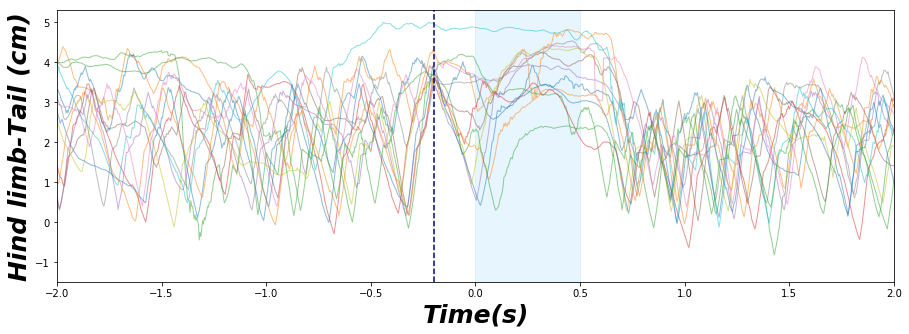

In [49]:
folder = 'Square_1_mW' ; opto_par = 'ChR2'
gap = 2 # th aligning window in timesteps
align = 50 # align at  -align timesteps
height=3.5 # lower cut for height of the peaks

path =os.path.join(pre_direct,'data_npz',folder,opto_par,'Limb_Tail')
file = list_all_files(path,'.npz')[0]
print(file)
properties= file[:-4].split("_")
dat = np.load(os.path.join(path,file))
epochs_limb = dat['epochs_all_mice_limb']
epochs_tail = dat['epochs_all_mice_tail']

ep_rel_limb_tail = epochs_limb - epochs_tail
fig = plt.figure(figsize=(15,5))
pre_interval = int(int(properties[-4])*t_window_dict['fps']/1000)
interval = intervals_dict['interval'];
post_interval = int(int(properties[-1])*t_window_dict['fps']/1000)

selected = np.full((ep_rel_limb_tail.shape[0]),False) #the epochs chosen for plot
for i in range(ep_rel_limb_tail.shape[0]):
    #peaks, _ = find_peaks(ep_rel_limb_tail[i,:], height=6.5)
    peaks, _ = find_peaks(ep_rel_limb_tail[i,:], height)
    
    if sum(np.logical_and(pre_interval-align -gap < peaks,peaks < pre_interval-align+ gap)) :
        selected[i] = True
        
        time_series = np.arange(-pre_interval,interval+post_interval+1)/fps
        plt.plot(time_series, ep_rel_limb_tail[i,:],linestyle='-',linewidth=1,alpha = 0.5)#, marker='o',markersize=1)
plt.axvspan(0, interval/fps, alpha=0.2, color='lightskyblue')
plt.xlim(-2,2)
plt.axvline(x=(-align+gap/2)/fps, c= 'navy',ls='--')
plt.ylabel("Hind limb-Tail (cm)", fontproperties=font_label).set_fontproperties(font_label)
plt.xlabel("Time(s)", fontproperties=font_label).set_fontproperties(font_label)
plt.savefig(os.path.join(path,'Hlimb_rel_tail.png'),bbox_inches='tight',orientation='landscape',dpi=350)


### One limb pre|on|post laser

Since the right and left for limbs are usually in opposite phase we can neither average them nor use them to remove jitters. We only spot jumps in one side and remove them.

Choose the limb in the options. Then it will sort the trials depending on the starting point on the treadmill and plot. The default shows right side, set `left_or_right` to `'left'` to see the left side.
Set the values `mouse_type`, `opto_par`, `mouse_no`,`folder` and intervals.

Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
4
 1. X 
 2. Y 
1
 1. Position 
 2. Velocity 
 
1
session 1 out of 5
# jitter in mean(righ,left)  =  6400
# jitter in mean(righ,left)  =  7361
0  trials discarded
session 2 out of 5
# jitter in mean(righ,left)  =  8721
# jitter in mean(righ,left)  =  9719
0  trials discarded
session 3 out of 5
# jitter in mean(righ,left)  =  9499
# jitter in mean(righ,left)  =  10122
0  trials discarded
session 4 out of 5
# jitter in mean(righ,left)  =  8721
# jitter in mean(righ,left)  =  9800
0  trials discarded
session 5 out of 5
# jitter in mean(righ,left)  =  9504
# jitter in mean(righ,left)  =  10851
0  trials discarded


/home/shiva/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


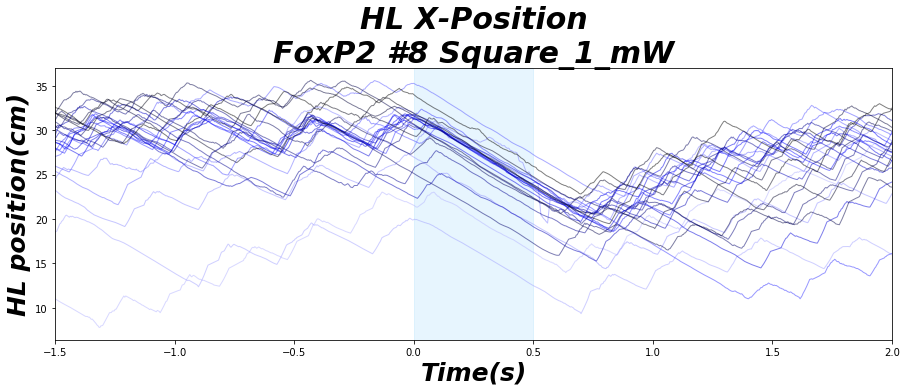

In [6]:
mouse_type= 'FoxP2';opto_par = "ChR2"; mouse_no = 8; folder = "Square_1_mW"
# mouse_type= 'D2';opto_par = "ChR2"; mouse_no = 199; folder = "Square_1_mW"

pre_interval = 375; interval = 125; post_interval = 375 ; left_or_right ='right'

study_param_dict = get_input_cor_body_part(**exp_dict) # decide to average over what and which coordinates
direct = os.path.join(pre_direct,mouse_type,opto_par,'Mouse_' + str(mouse_no)) # directory to the folder for each mouse
convert_csv_to_xlsx(os.path.join(direct,folder,'DLC'))
convert_csv_to_xlsx(os.path.join(direct,folder,'Laser')) # files might be given in csv, this is to unify 
files_list_DLC = list_all_files(os.path.join(direct,folder,'DLC'),".xlsx")
files_list_Laser = list_all_files(os.path.join(direct,folder,'Laser'),".xlsx")

epochs = extract_epochs_over_trials_one_side_one_body_part(files_list_DLC,files_list_Laser,direct,folder,
                     scale_pix_to_cm,accep_interval_range,misdetection_dict,
                    pre_interval,interval,post_interval,**t_window_dict,**study_param_dict,left_or_right = left_or_right) 

gap = 3
align = 100
selected = np.full((epochs.shape[0]),False) #the epochs chosen for plot
pre_stim_x = np.empty((epochs.shape[0])) #the epochs chosen for plot
time_series = np.arange(-pre_interval,interval+post_interval+1)/fps
for i in range(epochs.shape[0]):
    peaks, _ = find_peaks(epochs[i,:], height=6.5)
    if sum(np.logical_and(pre_interval-align -gap < peaks,peaks < pre_interval-align+ gap)) :
        selected[i] = True
        pre_stim_x[i] = np.average( epochs[i,:1])
        
ind, = np.where(selected)
pre_x = pre_stim_x[ind]
inds = pre_x.argsort()

red = Color("blue")
colors = list(red.range_to(Color("green"),len(pre_x)))
fig = plt.figure(figsize=(15,5))
lightness = np.linspace(0.3,2,len(pre_x))

for i in range(len(pre_x)):
    plt.plot(time_series, epochs[ind[inds[i]],:],linestyle='-',linewidth=1,color =lighten_color('b', lightness[i]),alpha = 0.5)#, marker='o',markersize=1)


plt.axvspan(0, interval/fps, alpha=0.2, color='lightskyblue')
plt.xlim(-pre_interval/fps,(interval+post_interval)/fps)
plt.title(study_param_dict['body_part'][0]+' X-Position'+'\n'+mouse_type+' #'+str(mouse_no)+' '+folder).set_fontproperties(font)

plt.ylabel(study_param_dict['body_part'][0]+' position(cm)', fontproperties=font_label).set_fontproperties(font_label)
plt.xlabel("Time(s)", fontproperties=font_label).set_fontproperties(font_label)
plt.savefig(os.path.join(pre_direct,'Subplots',study_param_dict['body_part'][0]+'_'+mouse_type+'_mouse_#'+
                         str(mouse_no)+'.png'),bbox_inches='tight',orientation='landscape',dpi=350)


## Look at a single measure in one session

D2_196_STR_alone_1mW_square_pulses_b_13_DLC.xlsx
Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1
 1. Position 
 2. Velocity 
 
1
 1. Right & Left 
 2. Average of both
2
2
Looking at --- Tail ---
There's a shift between left and right detections. Don't worry we will fix it!
# inconsistent right left =  0
# jitter in mean(righ,left)  =  86
Looking at --- Nose ---
# inconsistent right left =  0
# jitter in mean(righ,left)  =  157


/home/shiva/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


(23, 55)

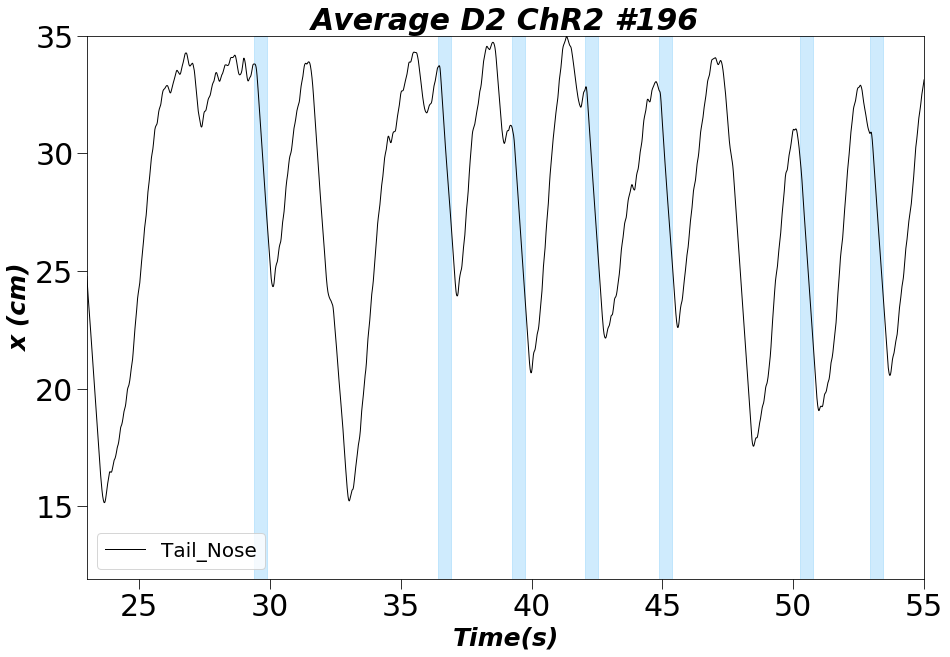

In [4]:
trial_no = 13 # trial number
i = 0 # which session to look at
mouse_type= 'D2';opto_par = "ChR2"; mouse_no = 196; spont = "n"; folder = "Square_1_mW"

path = os.path.join(pre_direct, mouse_type, opto_par, 'Mouse_' +str(mouse_no)) # directory to the folder for each mouse
files_list_DLC = list_all_files(os.path.join(path,folder,'DLC'),'.xlsx')
files_list_Laser = list_all_files(os.path.join(path,folder,'Laser'),'.xlsx')
print(files_list_DLC[i])
df = read_DLC(os.path.join(path,folder,"DLC",files_list_DLC[i]),scale_pix_to_cm)
laser_t = read_laser(os.path.join(path,folder,"Laser",files_list_Laser[i]))

input_plot(df, laser_t,mouse_type,mouse_no,trial_no,opto_par,pre_direct,exp_dict,t_window_dict, misdetection_dict,
                        save_as_format = '.pdf')
plt.xlim(23,55)

# Categorize trials by pre-laser X/V and Plot by distinction

## Phase space, Violin plot, ..

First read the stored data and make transform it to a dataframe:

In [5]:
# mouse_type = 'D2';
# folder = 'STR'; 
folder = 'Square_1_mW'
mouse_type = 'FoxP2';opto_par = 'ChR2'
# folder = "GP"

# mouse_type = 'Vglut2'
# folder = 'STN+GP'; 
# folder = 'STN_3_mice'; 
# folder = 'GP'; 
# folder = 'STN'; 

path = os.path.join(pre_direct,'data_npz',folder,opto_par)
files_list = list_all_files(path,".npz")
file_path_list = [os.path.join(path,file) for file in files_list]
result_val = read_npz_return_data_frame(file_path_list,**intervals_dict)
result = categorize_pre_x_and_v(result_val,**pre_x_v_dict)
print(result.head())

/home/shiva/Desktop/Shiva_Behavior/data_npz/Square_1_mW/ChR2/D2_ChR2_Square_1_mW_mov_aver=40_n_t=120_x_velocity_Tail_Nose.npz
(748,) (748, 501)
/home/shiva/Desktop/Shiva_Behavior/data_npz/Square_1_mW/ChR2/FoxP2_ChR2_Square_1_mW_mov_aver=40_n_t=120_x_velocity_Tail_Nose.npz
(711,) (711, 501)
/home/shiva/Desktop/Shiva_Behavior/data_npz/Square_1_mW/ChR2/Vglut2_ChR2_Square_1_mW_mov_aver=40_n_t=120_x_velocity_Tail_Nose.npz
(778,) (778, 501)
   mean_velocity  min_velocity                 mouse_type  \
0      11.142249      7.185797  /home/shiva/Desktop/Shiva   
1       3.893347     -6.619796  /home/shiva/Desktop/Shiva   
2       6.924647     -9.964127  /home/shiva/Desktop/Shiva   
3     -10.969371    -18.585969  /home/shiva/Desktop/Shiva   
4      -1.638380     -7.422673  /home/shiva/Desktop/Shiva   

  optogenetic expression  pulse_type intensity_mW epoch pre_velocity_pos_neg  \
0          Behavior/data  npz/Square            1   OFF                  pos   
1          Behavior/data  npz/Squa

The plot:

/home/shiva/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


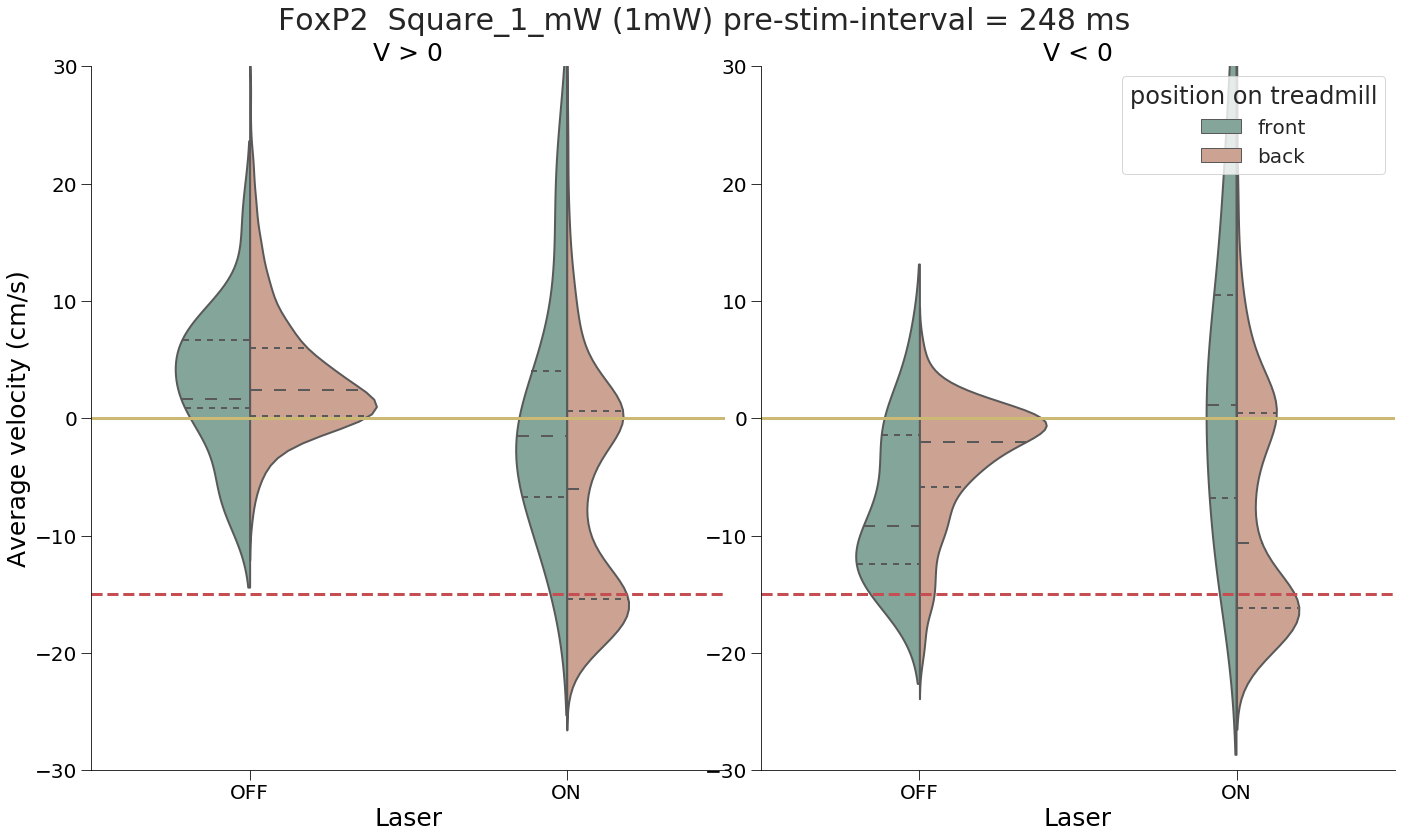

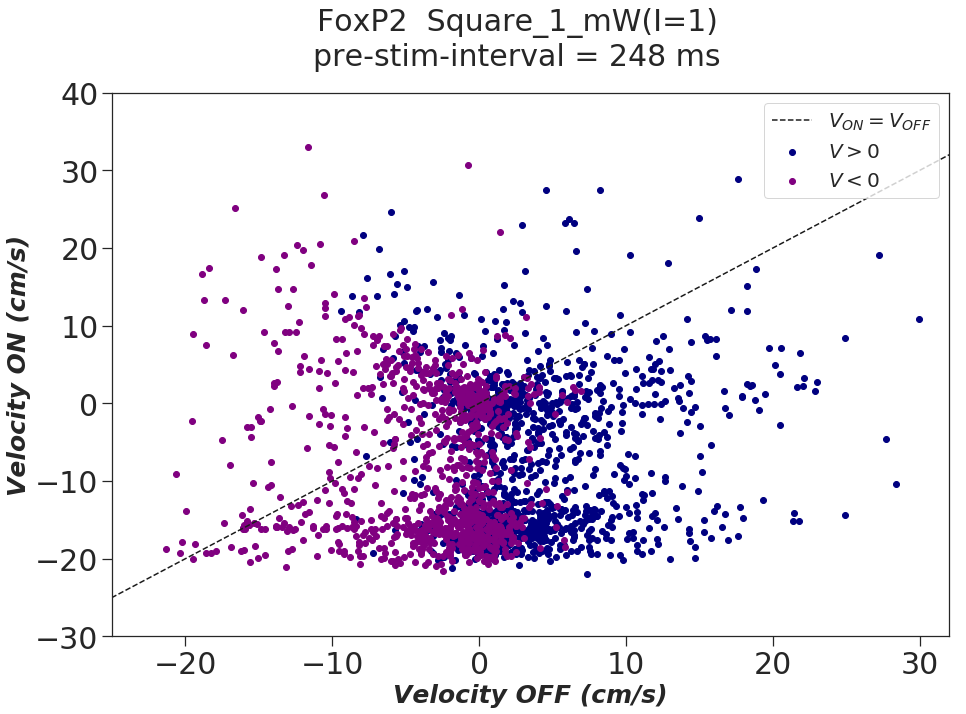

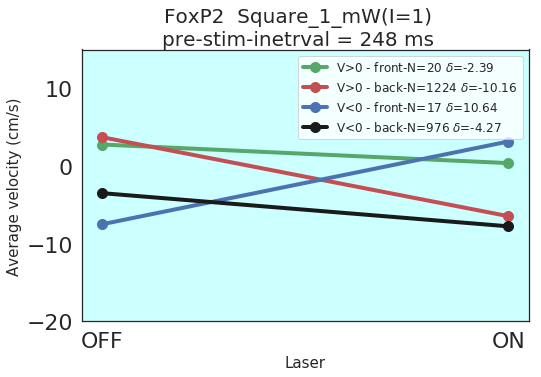

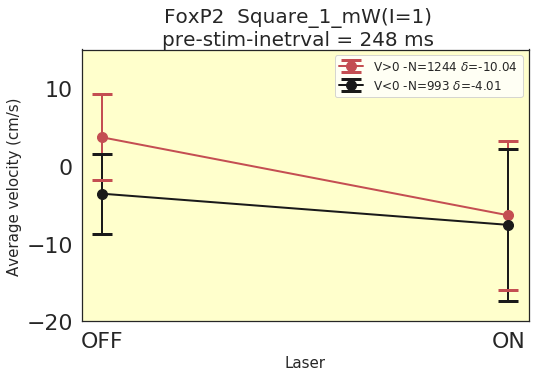

In [5]:
violin_plot_X_V_distiction(result, path, mouse_type, folder,t_window_dict['fps'],**pre_x_v_dict,
                           ylim=[-30,30],save_as_format='.pdf')
plot_phase_space_V(result,path,mouse_type,folder,t_window_dict['fps'],**pre_x_v_dict,
                   xlim=[-25,32],ylim=[-30,40],save_as_format='.pdf')
Plot_ON_OFF_X_V_mean(result,path,mouse_type,folder,t_window_dict['fps'],**pre_x_v_dict,
                     ylim=[-20,15],save_as_format='.pdf')
Plot_ON_OFF_V_mean(result,path,mouse_type,folder,t_window_dict['fps'],**pre_x_v_dict,
                   ylim=[-20,15],save_as_format='.pdf')

## Stats on minimum velocity during laser with velocity distinction

### Different mouse types

/home/shiva/Desktop/Shiva_Behavior/data_npz/Square_1_mW/ChR2/D2_ChR2_Square_1_mW_mov_aver=40_n_t=120_x_velocity_Tail_Nose.npz
/home/shiva/Desktop/Shiva_Behavior/data_npz/Square_1_mW/ChR2/D2_ChR2_Square_1_mW_mov_aver=40_n_t=120_x_velocity_Tail_Nose.npz
(748,) (748, 501)
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

pos v.s. neg: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.811e-04 U_stat=7.948e+04
/home/shiva/Desktop/Shiva_Behavior/data_npz/Square_1_mW/ChR2/FoxP2_ChR2_Square_1_mW_mov_aver=40_n_t=120_x_velocity_Tail_Nose.npz
/home/shiva/Desktop/Shiva_Behavior/data_npz/Square_1_mW/ChR2/FoxP2_ChR2_Square_1_mW_mov_aver=40_n_t=120_x_velocity_Tail_Nose.npz
(711,) (711, 501)
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

pos v.s. neg: 

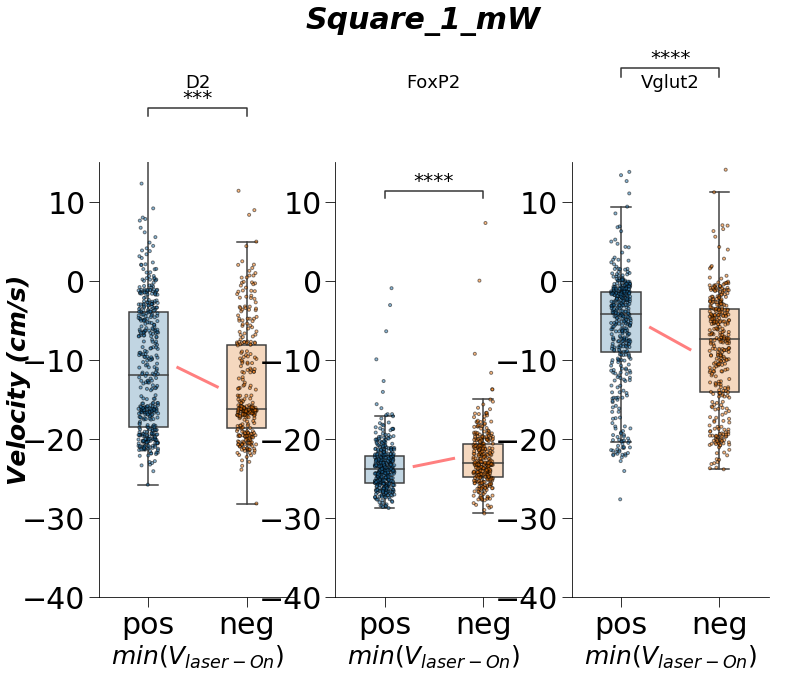

In [7]:
folder= 'Square_1_mW';opto_par = 'ChR2'
path = os.path.join(pre_direct,'data_npz',folder,opto_par)
files_list = list_all_files(path,'.npz')
file_path_list = [os.path.join(path,file) for file in files_list]


min_velocity_mouse_type_box_plot(file_path_list,path,interval_dict,pre_x_v_dict,ylim=[-40,15],save_as_format = '.pdf')


### One type, different intensities

FoxP2_ChR2_Square_0-25_mW_mov_aver=40_n_t=120_x_velocity_Tail_Nose.npz
/home/shiva/Desktop/Shiva_Behavior/data_npz/Square_0-25_mW/ChR2/FoxP2_ChR2_Square_0-25_mW_mov_aver=40_n_t=120_x_velocity_Tail_Nose.npz
(245,) (245, 501)
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

pos v.s. neg: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.150e-01 U_stat=6.925e+03
FoxP2_ChR2_Square_0-5_mW_mov_aver=40_n_t=120_x_velocity_Tail_Nose.npz
/home/shiva/Desktop/Shiva_Behavior/data_npz/Square_0-5_mW/ChR2/FoxP2_ChR2_Square_0-5_mW_mov_aver=40_n_t=120_x_velocity_Tail_Nose.npz
(316,) (316, 501)
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

pos v.s. neg: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.059e-01 U_stat=1.116e+04
Fox

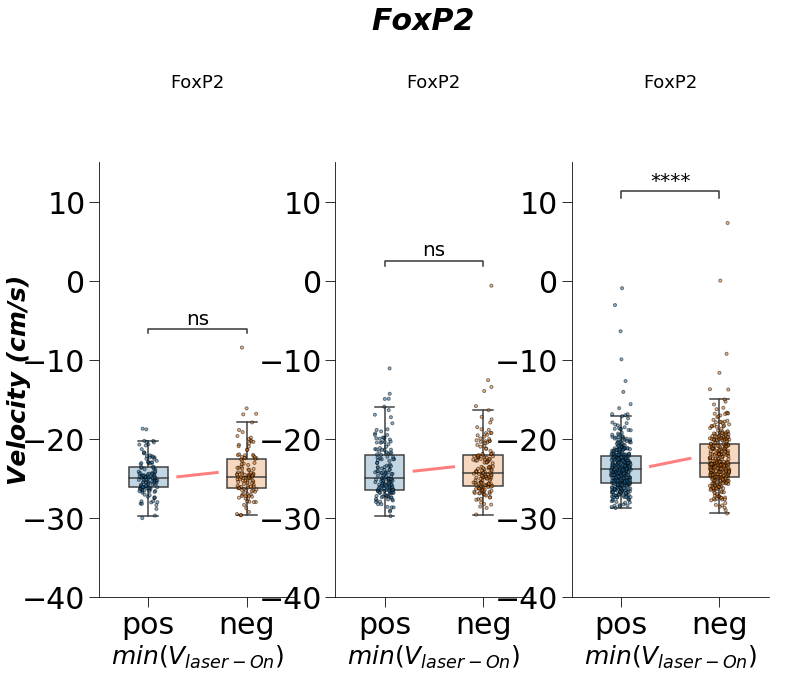

In [6]:
mouse_type = 'FoxP2';opto_par = 'ChR2'
folder_list = ['Square_0-25_mW','Square_0-5_mW','Square_1_mW']
path = os.path.join(pre_direct,'data_npz')
file_path_list = []
for folder in folder_list:
    files = list_all_files(os.path.join(path,folder,opto_par),'.npz')
    files = list(map(lambda orig_string: os.path.join(path,folder,opto_par,orig_string), files))
    file_path_list.extend(files)

file_path_list = list(filter(lambda k: mouse_type in k, file_path_list))
# print(file_path_list)
min_velocity_diff_inten_box_plot(file_path_list,path,intervals_dict,pre_x_v_dict,ylim=[-40,15],save_as_format = '.pdf')


## Look at average velocity by pre-laser X position distinction

VGlut_ChR2_Square_1_mW_pre_x_pre_v_pre_stim_inter=125_mov_aver=10_n_t=30.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
3.423680482398385
0.07032386267492569
29.914298444381817
11.533333333333333
front 730
back 48
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']


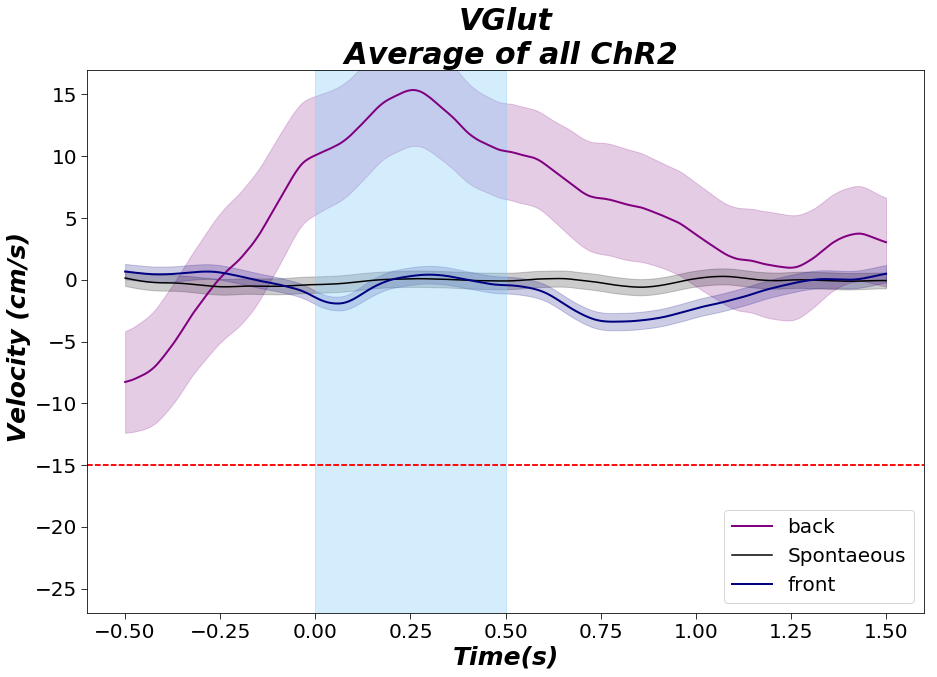

In [48]:
def plot_pre_on_post_v(epochs,epochs_spont,color,label,spont ):
    ''' plot (pre Laser/ON-Laser/post Laser) velocity comparison between active trials and spontaneous'''
    
    epochs_mean = np.average(epochs, axis = 0) # average over different stimuli
    epochs_mean_spont = np.average(epochs_spont, axis = 0) # average over different stimuli

    confidence_inter = np.empty((0,2), int)
    
    if len(epochs.shape) > 1 :
        epochs_mean = np.average(epochs, axis = 0)
        epochs_mean_spont = np.average(epochs_spont, axis = 0)
        
        for i in range (epochs.shape[1]): #calculate the two sided confidence interval for every timestep
            m = [sms.DescrStatsW(epochs[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
            confidence_inter = np.append(confidence_inter,[[m[0][0],m[0][1]]],axis=0)
        confidence_inter_spont = np.empty((0,2), int)
        
        for i in range (epochs_spont.shape[1]):
            m = [sms.DescrStatsW(epochs_spont[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
            confidence_inter_spont = np.append(confidence_inter_spont,[[m[0][0],m[0][1]]],axis=0)
    else:
        epochs_mean = epochs
        epochs_mean_spont = epochs_spont
        confidence_inter = np.zeros(((epochs_mean.shape[0]),2))
        confidence_inter_spont = np.zeros((epochs_mean.shape[0],2))
    time_series = np.arange(-pre_interval,interval+post_interval+1)/fps
    
    plt1,=plt.plot(time_series, epochs_mean, color = color, label = label , linestyle='-',linewidth=2)#, marker='o',markersize=1)
    plt.fill_between(time_series, confidence_inter[:,0],  confidence_inter[:,1], color=color, alpha=0.2)
    
    if spont == True:
        plt2,=plt.plot(time_series, epochs_mean_spont, color = 'k', label = "Spontaeous")
        plt.fill_between(time_series, confidence_inter_spont[:,0],  confidence_inter_spont[:,1], color='k', alpha=0.2)
    
    plt.axvspan(0, interval/fps, alpha=0.2, color='lightskyblue')


    if plot_param_list[what_plot] == 'velocity':
        plt.ylabel(" Velocity (cm/s)").set_fontproperties(font_label)
    else:
        plt.ylabel(" Position (cm)").set_fontproperties(font_label)
        
    plt.axhline( y = treadmill_velocity, ls='--', c='red')
    
    plt.xlabel("Time(s)").set_fontproperties(font_label)
    plt.ylim(min_y_pre_post,max_y_pre_post) #set limits
    plt.legend(fontsize = 10)
#     plt.xlim(-.5,2) #set limits

#     handles =np.array([plt1,plt2])
    
    ax.get_xaxis().set_tick_params(direction='out',labelsize = 20 ,length=6)
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_tick_params(direction='out',labelsize = 20, length=6)
    ax.yaxis.set_ticks_position('left')
    plt.legend(loc = 'lower right',fontsize =20)

#     plt.legend(handles=handles[handles_ind].tolist(),labels=labels,loc = 'lower right',fontsize =20)
    plt.title( mouse_type+"\n"+" Average of all "+opto_par).set_fontproperties(font)
#     plt.axhline( y = 17, ls='--', c='g')
   

back_front_boundary =  (treadmill_len-elec_shock)/3 # set the limit below which is considered back of the treadmill

where_plot,which_plot, what_plot = [0,1],0,1 # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user

# mouse_type = 'D2' ; folder = 'STR' ; opto_par = 'ChR2'
# mouse_type = 'FoxP2' ; folder = 'GP' ; opto_par = 'ChR2'
mouse_type = 'Vglut2' ; folder = 'STN' ; opto_par = 'ChR2'


path = os.path.join(pre_direct,'data_npz','Distinction','ChR2',mouse_type,folder)
files = list_all_files(path,".npz")
file = files[0]
print(file)
dat = np.load(os.path.join(path,file))
properties=file.split("_")
print(dat.files)
epochs = dat[dat.files[0]]
pre_x = dat[dat.files[1]]
print(np.average(pre_x))
print(np.min(pre_x))
print(np.max(pre_x))
print(back_front_boundary)
ind,  = np.where(pre_x < back_front_boundary)
print("front",len(ind))
# print(np.sort(pre_x)/scale_pix_to_cm)
epochs_v_front = epochs[ind,:]
ind,  = np.where(pre_x > back_front_boundary)
print("back",len(ind))
epochs_v_back = epochs[ind,:]
folder = "Square_1_mW"
path_main = os.path.join(pre_direct,'data_npz', folder, 'ChR2')

extension_summary = ".npz"
summary_files_list = list_all_files(os.path.join(pre_direct,'data_npz',folder,'ChR2',extension_summary))
for file in summary_files_list:
    if file.split("_")[0] == mouse_type:
        dat = np.load(os.path.join(path_main,file))
        print(dat.files)
        epochs_spont = dat['epochs_spont_all_mice']
        break
        
pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
plot_pre_on_post_v(epochs_v_back,epochs_spont[:epochs_v_front.shape[0]],'purple','back', spont = True)
plot_pre_on_post_v(epochs_v_front,np.zeros((epochs_v_less.shape)),'navy','front',spont = False)
plt.savefig(os.path.join(path,'V_X_distinction'+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_Velociy_' +
                str(n_timebin)+ '_mov_ave_win='+str(window)+'_pre_post_stim.png'),bbox_inches='tight',
                orientation='landscape',dpi=300)

## Look at average velocity by pre-laser velocity distinction

FoxP2_ChR2_Square_0-25_mW_pre_x_pre_v_pre_stim_inter=125_mov_aver=10_n_t=30_x_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
(287, 501)
FoxP2_ChR2_Square_0-25_mW_mov_aver=10_n_t=30_x_Tail_Nose.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']


/home/shiva/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


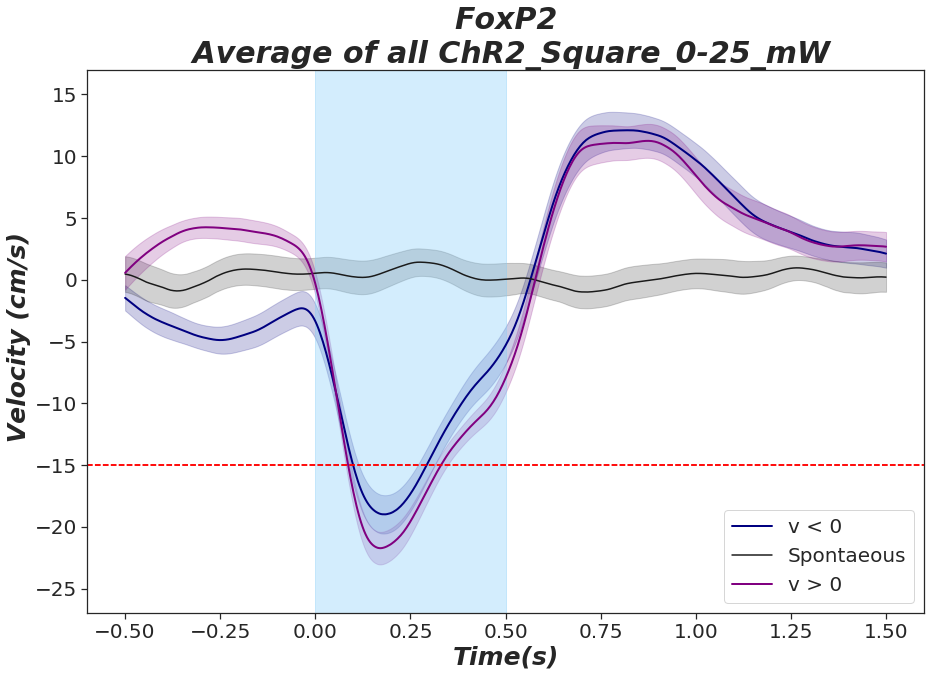

In [18]:
def plot_pre_on_post_v(epochs,epochs_spont,color,label,spont, folder ):
    ''' plot (pre Laser/ON-Laser/post Laser) velocity comparison between active trials and spontaneous'''
    
    epochs_mean = np.average(epochs, axis = 0) # average over different stimuli
    epochs_mean_spont = np.average(epochs_spont, axis = 0) # average over different stimuli

    confidence_inter = np.empty((0,2), int)
    
    if len(epochs.shape) > 1 :
        epochs_mean = np.average(epochs, axis = 0)
        epochs_mean_spont = np.average(epochs_spont, axis = 0)
        
        for i in range (epochs.shape[1]): #calculate the two sided confidence interval for every timestep
            m = [sms.DescrStatsW(epochs[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
            confidence_inter = np.append(confidence_inter,[[m[0][0],m[0][1]]],axis=0)
        confidence_inter_spont = np.empty((0,2), int)
        
        for i in range (epochs_spont.shape[1]):
            m = [sms.DescrStatsW(epochs_spont[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
            confidence_inter_spont = np.append(confidence_inter_spont,[[m[0][0],m[0][1]]],axis=0)
    else:
        epochs_mean = epochs
        epochs_mean_spont = epochs_spont
        confidence_inter = np.zeros(((epochs_mean.shape[0]),2))
        confidence_inter_spont = np.zeros((epochs_mean.shape[0],2))
    time_series = np.arange(-pre_interval,interval+post_interval+1)/fps
    
    plt1,=plt.plot(time_series, epochs_mean, color = color, label = label , linestyle='-',linewidth=2)#, marker='o',markersize=1)
    plt.fill_between(time_series, confidence_inter[:,0],  confidence_inter[:,1], color=color, alpha=0.2)
    
    if spont == True:
        plt2,=plt.plot(time_series, epochs_mean_spont, color = 'k', label = "Spontaeous")
        plt.fill_between(time_series, confidence_inter_spont[:,0],  confidence_inter_spont[:,1], color='k', alpha=0.2)
    
    plt.axvspan(0, interval/fps, alpha=0.2, color='lightskyblue')


    if plot_param_list[what_plot] == 'velocity':
        plt.ylabel(" Velocity (cm/s)").set_fontproperties(font_label)
    else:
        plt.ylabel(" Position (cm)").set_fontproperties(font_label)
        
    plt.axhline( y = treadmill_velocity, ls='--', c='red')
    
    plt.xlabel("Time(s)").set_fontproperties(font_label)
    plt.ylim(min_y_pre_post,max_y_pre_post) #set limits
    plt.legend(fontsize = 10)
#     plt.xlim(-.5,2) #set limits

#     handles =np.array([plt1,plt2])
    
    ax.get_xaxis().set_tick_params(direction='out',labelsize = 20 ,length=6)
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_tick_params(direction='out',labelsize = 20, length=6)
    ax.yaxis.set_ticks_position('left')
    plt.legend(loc = 'lower right',fontsize =20)

#     plt.legend(handles=handles[handles_ind].tolist(),labels=labels,loc = 'lower right',fontsize =20)
    plt.title( mouse_type+"\n"+" Average of all "+opto_par+'_'+folder).set_fontproperties(font)
#     plt.axhline( y = 17, ls='--', c='g')
   


where_plot,which_plot, what_plot = [0,1],0,1 # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user

# mouse_type = 'D2' ; folder = 'STR'
mouse_type = 'FoxP2' ; folder = 'GP'
# mouse_type = 'Vglut2' ; folder = 'STN'



path = os.path.join(pre_direct,'data_npz','Distinction','ChR2', mouse_type, folder)
files = list_all_files(path,".npz")
file = files[0]
print(file)
dat = np.load(path+'/'+file)
properties=file.split("_")
print(dat.files)
epochs = dat[dat.files[0]]
pre_v = dat[dat.files[2]]
print(dat[dat.files[0]].shape)
ind,  = np.where(pre_v < 0)
epochs_v_less = epochs[ind,:]
ind,  = np.where(pre_v > 0)
epochs_v_more = epochs[ind,:]

# folder = "Square_1_mW"
# folder = "Square_0-5_mW"
folder = "Square_0-25_mW"

path_main = os.path.join(pre_direct,'data_npz',folder,'ChR2')

extension_summary = ".npz"
summary_files_list = list_all_files(os.path.join(pre_direct,'data_npz',folder,'ChR2',extension_summary))
for file in summary_files_list:
    if file.split("_")[0] == mouse_type:
        dat = np.load(os.path.join(path_main,file))
        print(file)
        print(dat.files)
        epochs_spont = dat['epochs_spont_all_mice']
        break
        
pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
plot_pre_on_post_v(epochs_v_less,epochs_spont[:epochs_v_less.shape[0]],'navy','v < 0', True,folder)
plot_pre_on_post_v(epochs_v_more,np.zeros((epochs_v_less.shape)),'purple','v > 0',False, folder)
plt.savefig(os.path.join(path,'V_distinction'+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_Velociy_' +
                str(n_timebin)+ '_mov_ave_win='+str(window)+'_pre_post_stim.pdf'),bbox_inches='tight',
                orientation='landscape',dpi=300)

### CTR

D2_Control_Square_1_mW_mov_aver=10n_t=30.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
FoxP2_Control_Square_1_mW_mov_aver=10n_t=30.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
VGlut_Control_Square_1_mW_mov_aver=10n_t=30.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']


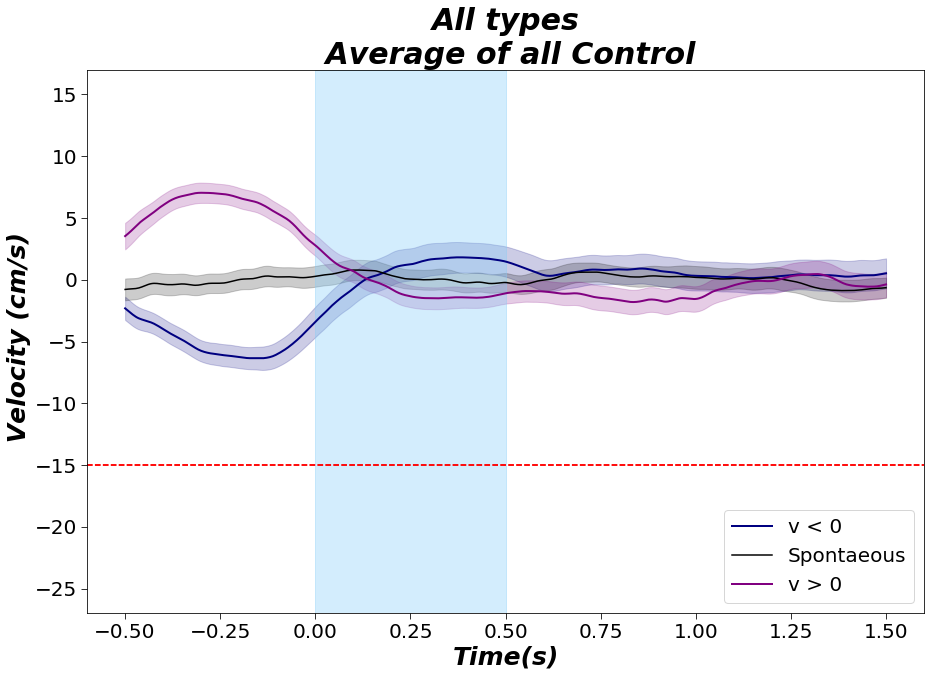

In [8]:
where_plot, which_plot, what_plot = [0,1],0,1 # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user


folder = "Square_1_mW"
path =pre_direct+'data_npz/'+folder+'/Control/'
extension_summary = ".npz"
Summary_files_list = list_all_files(path,extension_summary)
epochs_all_ctr = np.empty((0,pre_interval+interval+post_interval+1))
epochs_spont_all_ctr = np.empty((0,pre_interval+interval+post_interval+1))
count = 0
for file in Summary_files_list:
    count = count+1
    print(file)
    dat = npzfile = np.load(path+file)
    print(dat.files)
    properties=file.split("_")
    epochs_all_ctr = np.append(epochs_all_ctr,dat['epochs_all_mice'], axis = 0)# construct an array of all the trial epochs of all mice
    epochs_spont_all_ctr = np.append(epochs_spont_all_ctr,dat['epochs_spont_all_mice'], axis = 0)# construct an array of all the trial epochs of all mice

#     epochs_spont_all_ctr = np.zeros((epochs_all_ctr.shape))
    global mouse_type; global opto_par
    mouse_type = 'All types'
    opto_par = properties[1]
    
opto_par = 'Control'
pre_v = np.average(epochs_all_ctr[:,:pre_stim_inter],axis = 1)
ind_less,  = np.where(pre_v < 0)
epochs_v_less = epochs_all_ctr[ind_less,:]
ind_more,  = np.where(pre_v > 0)
epochs_v_more = epochs_all_ctr[ind_more,:]
ind_spont  = np.random.randint(epochs_spont_all_ctr.shape[0], size=int((len(ind_more)+len(ind_less))/2))
path = '/home/shiva/Desktop/Shiva_Behavior/data_npz/Distinction/Control'
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
plot_pre_on_post_v(epochs_v_less,epochs_spont_all_ctr[ind_spont],'navy','v < 0', spont = True)
plot_pre_on_post_v(epochs_v_more,np.zeros((epochs_v_less.shape)),'purple','v > 0',spont = False)
plt.savefig(path+'/V_distinction'+'_'+folder+"_"+opto_par+'_'+ cor+ '_Velociy_' +
                str(n_timebin)+ '_mov_ave_win='+str(window)+'_pre_post_stim.pdf',bbox_inches='tight',
                orientation='landscape',dpi=300)

## Look at average position by pre-laser velocity distinction

FoxP2_ChR2_Square_1_mW_pre_x_pre_v_pre_stim_inter=125_mov_aver=10_n_t=30.npz
(711,)
FoxP2_x_ChR2_Square_1_mW_mov_aver=10_n_t=30.npz
['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice']
24.10706964955898


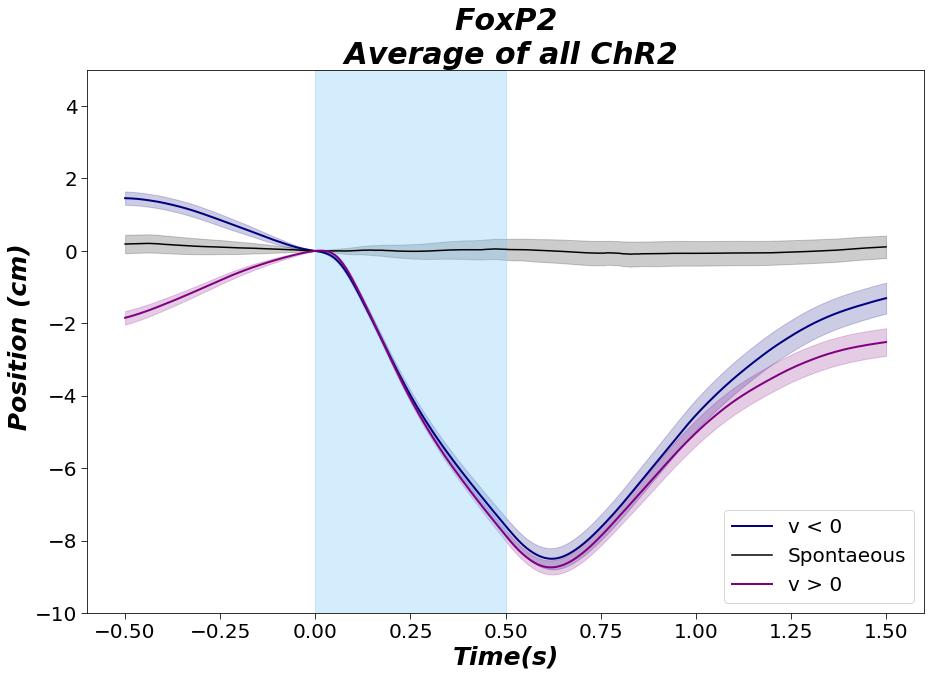

In [80]:
def plot_pre_on_post_v(epochs,epochs_spont,color,label,spont ):
    ''' plot (pre Laser/ON-Laser/post Laser) velocity comparison between active trials and spontaneous'''
    
    epochs_mean = np.average(epochs, axis = 0) # average over different stimuli
    epochs_mean_spont = np.average(epochs_spont, axis = 0) # average over different stimuli

    confidence_inter = np.empty((0,2), int)
    
    if len(epochs.shape) > 1 :
        epochs_mean = np.average(epochs, axis = 0)
        epochs_mean_spont = np.average(epochs_spont, axis = 0)
        
        for i in range (epochs.shape[1]): #calculate the two sided confidence interval for every timestep
            m = [sms.DescrStatsW(epochs[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
            confidence_inter = np.append(confidence_inter,[[m[0][0],m[0][1]]],axis=0)
        confidence_inter_spont = np.empty((0,2), int)
        
        for i in range (epochs_spont.shape[1]):
            m = [sms.DescrStatsW(epochs_spont[:,i]).tconfint_mean(alpha=0.05, alternative='two-sided')]
            confidence_inter_spont = np.append(confidence_inter_spont,[[m[0][0],m[0][1]]],axis=0)
    else:
        epochs_mean = epochs
        epochs_mean_spont = epochs_spont
        confidence_inter = np.zeros(((epochs_mean.shape[0]),2))
        confidence_inter_spont = np.zeros((epochs_mean.shape[0],2))
    time_series = np.arange(-pre_interval,interval+post_interval+1)/fps
    
    plt1,=plt.plot(time_series, epochs_mean, color = color, label = label , linestyle='-',linewidth=2)#, marker='o',markersize=1)
    plt.fill_between(time_series, confidence_inter[:,0],  confidence_inter[:,1], color=color, alpha=0.2)
    
    if spont == True:
        plt2,=plt.plot(time_series, epochs_mean_spont, color = 'k', label = "Spontaeous")
        plt.fill_between(time_series, confidence_inter_spont[:,0],  confidence_inter_spont[:,1], color='k', alpha=0.2)
    
    plt.axvspan(0, interval/fps, alpha=0.2, color='lightskyblue')


    if plot_param_list[what_plot] == 'velocity':
        plt.ylabel(" Velocity (cm/s)").set_fontproperties(font_label)
    else:
        plt.ylabel(" Position (cm)").set_fontproperties(font_label)
        
    plt.axhline( y = treadmill_velocity, ls='--', c='red')
    
    plt.xlabel("Time(s)").set_fontproperties(font_label)
    plt.ylim(-10,5) #set limits
    plt.legend(fontsize = 10)
#     plt.xlim(-.5,2) #set limits

#     handles =np.array([plt1,plt2])
    
    ax.get_xaxis().set_tick_params(direction='out',labelsize = 20 ,length=6)
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_tick_params(direction='out',labelsize = 20, length=6)
    ax.yaxis.set_ticks_position('left')
    plt.legend(loc = 'lower right',fontsize =20)

#     plt.legend(handles=handles[handles_ind].tolist(),labels=labels,loc = 'lower right',fontsize =20)
    plt.title( mouse_type+"\n"+" Average of all "+opto_par).set_fontproperties(font)
#     plt.axhline( y = 17, ls='--', c='g')
   


where_plot,which_plot, what_plot = [0,1],0,0 # decide to average over what and coordinates
cor = cor_list[which_plot] # gets either x or y by user

mouse_type = 'D2' ; folder = 'STR'
# mouse_type = 'FoxP2' ; folder = 'GP'

path = os.path.join(pre_direct,'data_npz','Distinction','ChR2',mouse_type,folder)
files = list_all_files(path,".npz")
file = files[0]
print(file)
dat = np.load(os.path.join(path_main,file))
properties=file.split("_")
epochs = dat[dat.files[0]]
pre_v = dat[dat.files[2]]
print(pre_v.shape)
ind_less,  = np.where(pre_v < 0)
ind_more,  = np.where(pre_v > 0)
folder = "Square_1_mW"

extension_summary = ".npz"
path_main = os.path.join(pre_direct,'data_npz',folder,'ChR2')
summary_files_list = list_all_files(os.path.join(pre_direct,'data_npz',folder,'ChR2'),extension_summary)
for file in summary_files_list:
    if file.split("_")[0] == mouse_type:
        print(file)
        dat = np.load(os.path.join(path_main,file))
        print(dat.files)
        epochs_spont = dat['epochs_spont_all_mice']
        print(np.max(epochs_spont))
        epochs_less = dat['epochs_all_mice'][ind_less]
        epochs_more = dat['epochs_all_mice'][ind_more]
        break
        
pre_interval = int(.5*fps) # interval before laser onset
post_interval = int(.5*fps*2) # interval after laser onset

pre_v = dat[dat.files[2]]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
plot_pre_on_post_v(epochs_less,epochs_spont[:epochs_less.shape[0]],'navy','v < 0', spont = True)
plot_pre_on_post_v(epochs_more,np.zeros((epochs_less.shape)),'purple','v > 0',spont = False)
plt.savefig(os.path.join(path,'X_distinction'+'_'+folder+"_"+opto_par+'_'+mouse_type+'_'+ cor+ '_Velociy_' +
                str(n_timebin)+ '_mov_ave_win='+str(window)+'_pre_post_stim.pdf'),bbox_inches='tight',
                orientation='landscape',dpi=300)

# Violin plots summerizing all the data 

## Different brain regions - same protocols (ChR2 animals)

/media/shiva/LaCie/Data_INCIA_Shiva_sorted/data_npz/STN/squarepulse_0-5_mW/ChR2/Vglut2D2_ChR2_STN_squarepulse_0-5_mW_mov_aver_window=40_V_window=120ms_x_velocity_Tail_Nose.npz ['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice', 'avg_pre_stim_position', 'avg_pre_stim_velocity', 'avg_pre_stim_acc', 'cor', 'body_part', 'plot_param']
shapiro : ShapiroResult(statistic=0.9860731959342957, pvalue=9.02685642358847e-05)
MW stat_result: MannwhitneyuResult(statistic=149056.0, pvalue=1.0670897647933835e-05)
Wilcoxon stat_result: WilcoxonResult(statistic=46550.0, pvalue=6.475634314064097e-08)
OFF 0.35202108145902294 0.361806580803339
ON -2.1798282986989057 0.4179824835016937
n_trials: (507, 501)
/media/shiva/LaCie/Data_INCIA_Shiva_sorted/data_npz/STR/squarepulse_0-5_mW/ChR2/Vglut2D2_ChR2_STR_squarepulse_0-5_mW_mov_aver_window=40_V_window=120ms_x_velocity_Tail_Nose.npz ['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice', 'avg_pre_stim_position', 'avg_pre_stim_vel

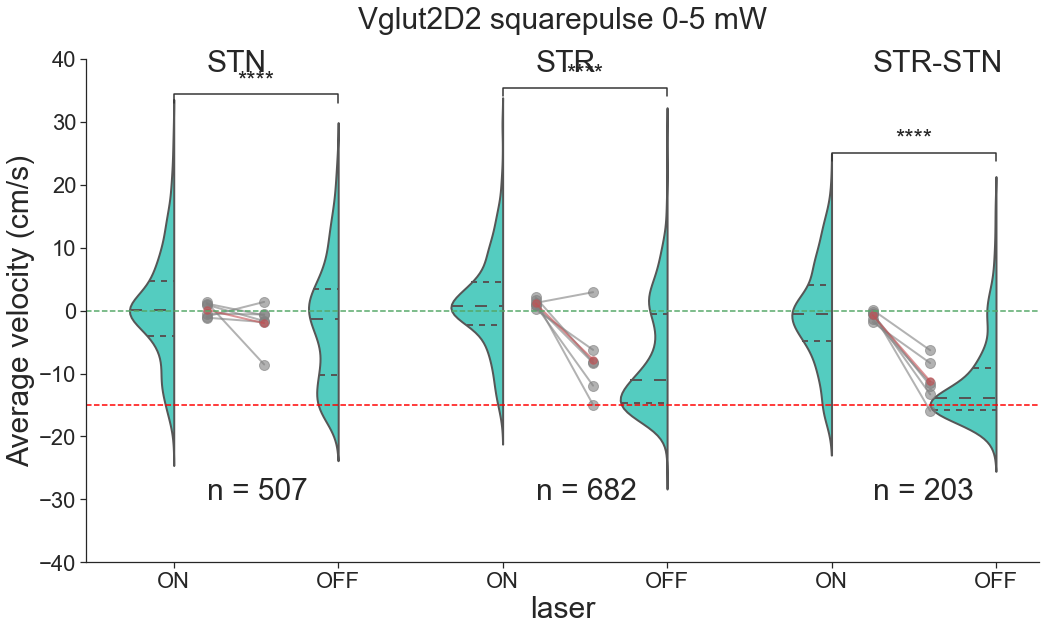

In [27]:
opto_par = 'ChR2'
mouse_type = 'Vglut2D2'
stim_type = 'squarepulse_0-5_mW'
# stim_type = 'squarepulse_1_mW'
stim_loc_list = ['STN', 'STR', 'STR-STN']
subplot_parameter = 'stim_loc'

subplot_param_list = stim_loc_list
add_title = mouse_type + ' '
figname = mouse_type + '_' + opto_par + '_stim_loc_' + stim_type


summary_files_list = get_all_filepaths_same_protocol(stim_loc_list, 
                                                     pre_direct, 
                                                     stim_type, 
                                                     opto_par)


summary_files_list = [f for f in summary_files_list if os.path.basename(f).split('_')[0] == mouse_type]
box_pairs, result, n_trials_dict, epochs_mean_mouse_dict = create_df_from_data_summary(summary_files_list, intervals_dict,
                                                                                  subplot_parameter = subplot_parameter,
                                                                                  opto_par = opto_par)


print(result.head())

sns.set(font_scale = 2)
sns.set_style("white")

g = sns.catplot(x = "epoch", y = "mean_velocity", 
                hue = "optogenetic expression", 
                data = result, kind = "violin",  palette = ['turquoise'],
                height = 5, scale_hue = False, linewidth = 2,
                inner = "quartile", split = True, scale = 'area',
                hue_order = ['ChR2','Control'], legend = False, gridsize = 100 )

ax = g.axes.flatten()[0]
add_stat_annotation(ax, data = result,
                    x = "epoch", y = "mean_velocity",
                    hue = "optogenetic expression",
                    box_pairs = box_pairs,
                    test='Wilcoxon', text_format='star', 
                    loc='inside', verbose=2)

x_series = [[0.2, 0.55], [2.2, 2.55], [4.25, 4.6]]#, [6.9, 7.25]]

ax = plot_individual_mice(ax, epochs_mean_mouse_dict, n_trials_dict, x_series, 
                         sub_title_y = 38, n_annotate_y = -30)

ax.axhline( y=0, ls='--', c='g')
ax.axhline( y=treadmill_velocity, ls='--', c='red')


(g.set_axis_labels("laser", "Average velocity (cm/s)", fontsize=30)
  .set_xticklabels(flatten([['ON', 'OFF'] *(len(box_pairs))]))
  .set(ylim = (-40, 40)))


ax.tick_params(direction='out')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_title(add_title + stim_type.replace('_', ' '), fontsize = 30,pad = 30)
g.fig.set_figwidth(25.0)
g.fig.set_figheight(10)

Directory.create_dir_if_not_exist(os.path.join(pre_direct, 'Subplots', 'Violin_plots' ))

fig = ax.get_figure()
save_pdf_png(fig, 
             os.path.join(pre_direct, 'Subplots','Violin_plots', figname ), 
             size = fig.get_size_inches()*fig.dpi)

## Different brain regions - different protocols (ChR2 animals)

/media/shiva/LaCie/Data_INCIA_Shiva_sorted/data_npz/STN/squarepulse_1_mW/ChR2/Vglut2_ChR2_STN_squarepulse_1_mW_mov_aver_window=40_V_window=120ms_x_velocity_Tail_Nose.npz ['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice', 'avg_pre_stim_position', 'avg_pre_stim_velocity', 'avg_pre_stim_acc', 'cor', 'body_part', 'plot_param']
shapiro : ShapiroResult(statistic=0.9497032761573792, pvalue=8.50878000378802e-16)
MW stat_result: MannwhitneyuResult(statistic=291278.0, pvalue=0.011146321988162419)
Wilcoxon stat_result: WilcoxonResult(statistic=153015.0, pvalue=0.49574102057781577)
OFF 0.05684891256369932 0.24269464825226028
ON 0.40001127696117006 0.29544481712133536
n_trials: (793, 501)
/media/shiva/LaCie/Data_INCIA_Shiva_sorted/data_npz/GPe/squarepulse_15_mW/ChR2/Vglut2_ChR2_GPe_squarepulse_15_mW_mov_aver_window=40_V_window=120ms_x_velocity_Tail_Nose.npz ['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice', 'avg_pre_stim_position', 'avg_pre_stim_velocity', 'a

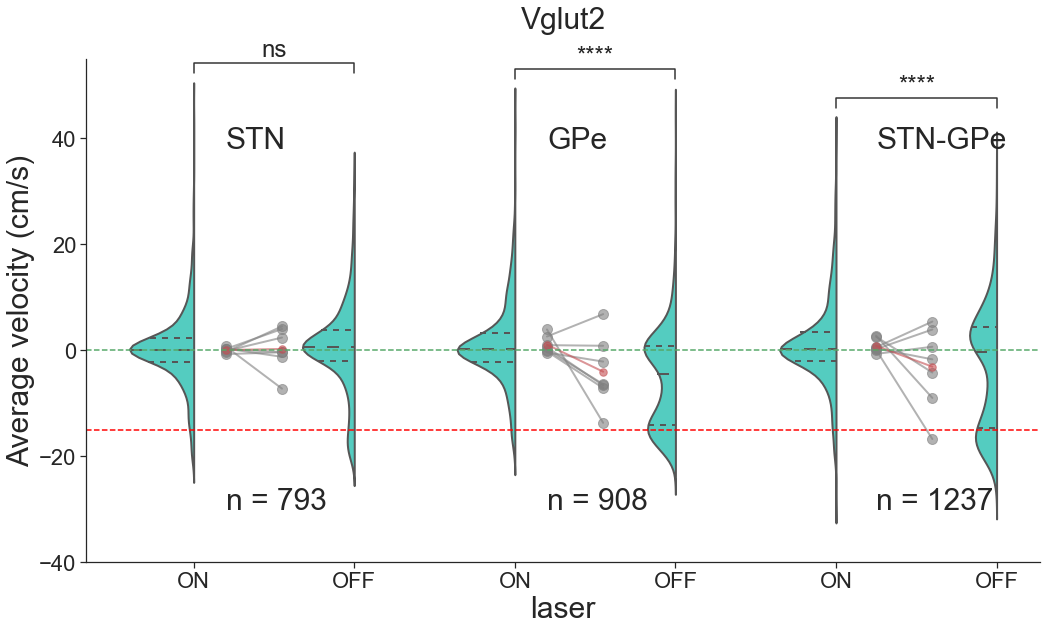

In [8]:
opto_par = 'ChR2'
mouse_type = 'Vglut2'

stim_loc_to_protocol = {'STN': 'squarepulse_1_mW', 
                        'GPe': 'squarepulse_15_mW', 
                        'STN-GPe': 'squarepulse_1-15_mW'}

stim_loc_list = list(stim_loc_to_protocol.keys())
subplot_parameter = 'stim_loc'
ylim = (-40, 55)
figname = '_'.join([mouse_type, opto_par]) + '_' + '_'.join(stim_loc_list)


summary_files_list = get_all_filepaths_same_protocol(stim_loc_list, 
                                                     pre_direct, 
                                                     list(stim_loc_to_protocol.values()), 
                                                     opto_par)
summary_files_list = [f for f in summary_files_list if os.path.basename(f).split('_')[0] == mouse_type]


box_pairs, result, n_trials_dict, epochs_mean_mouse_dict = create_df_from_data_summary(summary_files_list, intervals_dict,
                                                                                  subplot_parameter = subplot_parameter,
                                                                                  opto_par = opto_par)


print(result.head())

sns.set(font_scale = 2)
sns.set_style("white")

g = sns.catplot(x = "epoch", y = "mean_velocity", 
                hue = "optogenetic expression", 
                data = result, kind = "violin",  palette = ['turquoise'],
                height = 5, scale_hue = False, linewidth = 2,
                inner = "quartile", split = True, scale = 'area',
                hue_order = ['ChR2','Control'], legend = False, gridsize = 100 )

ax = g.axes.flatten()[0]
add_stat_annotation(ax, data = result,
                    x = "epoch", y = "mean_velocity",
                    hue = "optogenetic expression",
                    box_pairs = box_pairs,
                    test='Wilcoxon', text_format='star', 
                    loc='inside', verbose=2)

x_series = [[0.2, 0.55], [2.2, 2.55], [4.25, 4.6]]#, [6.9, 7.25]]

ax = plot_individual_mice(ax, epochs_mean_mouse_dict, n_trials_dict, x_series, 
                         sub_title_y = 38, n_annotate_y = -30)

ax.axhline( y=0, ls='--', c='g')
ax.axhline( y=treadmill_velocity, ls='--', c='red')


(g.set_axis_labels("laser", "Average velocity (cm/s)", fontsize=30)
  .set_xticklabels(flatten([['ON', 'OFF'] *(len(box_pairs))]))
  .set(ylim = (ylim)))


ax.tick_params(direction='out')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_title(mouse_type, fontsize = 30,pad = 30)
g.fig.set_figwidth(25.0)
g.fig.set_figheight(10)

Directory.create_dir_if_not_exist(os.path.join(pre_direct, 'Subplots', 'Violin_plots' ))

fig = ax.get_figure()
save_pdf_png(fig, 
             os.path.join(pre_direct, 'Subplots','Violin_plots', figname ), 
             size = fig.get_size_inches()*fig.dpi)

## Different brain regions - same protocol (Control animals)

/media/shiva/LaCie/Data_INCIA_Shiva_sorted/data_npz/STN/squarepulse_0-5_mW/Control/Vglut2D2_Control_STN_squarepulse_0-5_mW_mov_aver_window=40_V_window=120ms_x_velocity_Tail_Nose.npz ['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice', 'avg_pre_stim_position', 'avg_pre_stim_velocity', 'avg_pre_stim_acc', 'cor', 'body_part', 'plot_param']
shapiro : ShapiroResult(statistic=0.958142876625061, pvalue=0.0005056441295892)
MW stat_result: MannwhitneyuResult(statistic=8132.0, pvalue=0.6004971367771326)
Wilcoxon stat_result: WilcoxonResult(statistic=3732.0, pvalue=0.22204865752060687)
OFF 1.0951954251468738 0.7283603726646309
ON 0.7004976630942217 0.6006661939049645
n_trials: (130, 501)
/media/shiva/LaCie/Data_INCIA_Shiva_sorted/data_npz/STR/squarepulse_0-5_mW/Control/Vglut2D2_Control_STR_squarepulse_0-5_mW_mov_aver_window=40_V_window=120ms_x_velocity_Tail_Nose.npz ['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice', 'avg_pre_stim_position', 'avg_pre_stim_velo

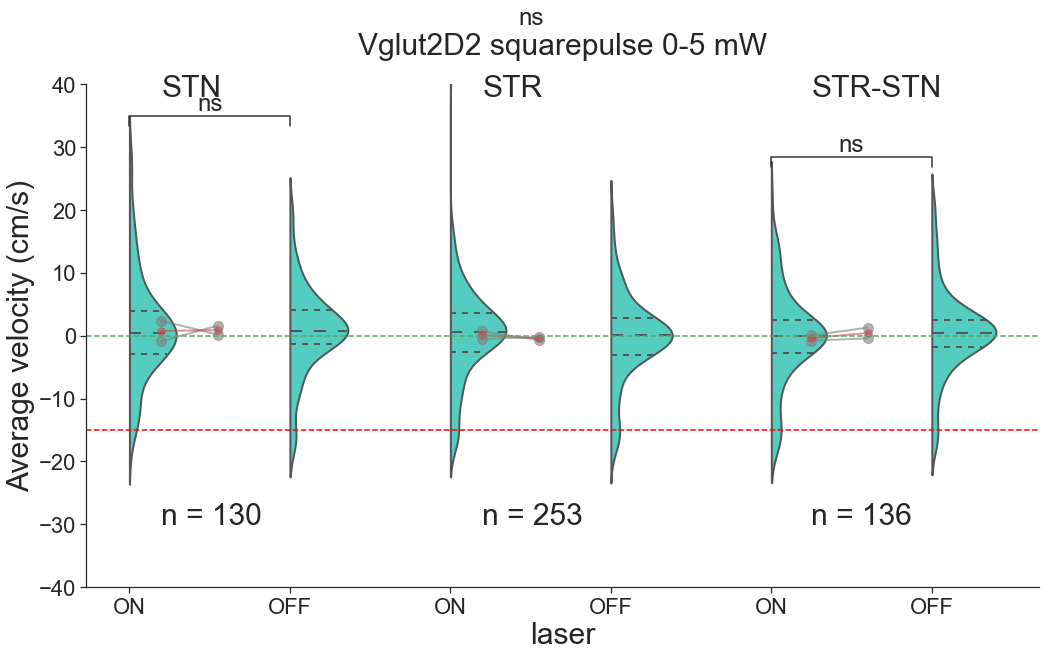

In [8]:
opto_par = 'Control'
mouse_type = 'Vglut2D2'
stim_type = 'squarepulse_0-5_mW'
# stim_type = 'squarepulse_1_mW'
stim_loc_list = ['STN', 'STR', 'STR-STN']
subplot_parameter = 'stim_loc'

subplot_param_list = stim_loc_list
add_title = mouse_type + ' '
figname = mouse_type + '_' + opto_par + '_stim_loc_' + stim_type


summary_files_list = get_all_filepaths_same_protocol(stim_loc_list, 
                                                     pre_direct, 
                                                     stim_type, 
                                                     opto_par)


summary_files_list = [f for f in summary_files_list if os.path.basename(f).split('_')[0] == mouse_type]


(box_pairs, 
 result_Ctrl_uniform, 
 n_trials_dict, 
 epochs_mean_mouse_dict) = create_df_from_data_summary(summary_files_list, 
                                                        intervals_dict,
                                                        subplot_parameter = subplot_parameter,
                                                        opto_par = opto_par,
                                                      uniform_ON_OFF = True)

(box_pairs, 
 result_Ctrl, 
 n_trials_dict, 
 epochs_mean_mouse_dict) = create_df_from_data_summary(summary_files_list, 
                                                        intervals_dict,
                                                        subplot_parameter = subplot_parameter,
                                                        opto_par = opto_par,
                                                      uniform_ON_OFF = False)

print(result_Ctrl.head())

sns.set(font_scale = 2)
sns.set_style("white")

g = sns.catplot(x = "epoch", y = "mean_velocity", 
                hue = "optogenetic expression", 
                data = result_Ctrl, kind = "violin",  palette = ['turquoise'],
                height = 5, scale_hue = False, linewidth = 2,
                inner = "quartile", split = True, scale = 'area',
                hue_order = ['ChR2','Control'], legend = False, gridsize = 100 )

ax = g.axes.flatten()[0]
add_stat_annotation(ax, data = result_Ctrl,
                    x = "epoch", y = "mean_velocity",
                    hue = "optogenetic expression",
                    box_pairs = box_pairs,
                    test='Wilcoxon', text_format='star', 
                    loc='inside', verbose=2)


print("shapiro :", stats.shapiro(result_Ctrl_uniform[result_Ctrl_uniform['epoch']=='OFF']['mean_velocity']- 
                                result_Ctrl_uniform[result_Ctrl_uniform['epoch']=='ON']['mean_velocity']))

print('overall wilcoxon', stats.wilcoxon(result_Ctrl_uniform[result_Ctrl_uniform['epoch']=='OFF']['mean_velocity'], 
                                         result_Ctrl_uniform[result_Ctrl_uniform['epoch']=='ON']['mean_velocity'], 
                                         zero_method='pratt', alternative='two-sided'))

x_series =[[0.2, 0.55], [2.2, 2.55], [4.25, 4.6]]#, [6.9, 7.25]]

ax = plot_individual_mice(ax, epochs_mean_mouse_dict, n_trials_dict, x_series, 
                         sub_title_y = 38, n_annotate_y = -30)

ax.axhline( y=0, ls='--', c='g')
ax.axhline( y=treadmill_velocity, ls='--', c='red')


(g.set_axis_labels("laser", "Average velocity (cm/s)", fontsize=30)
  .set_xticklabels(flatten([['ON', 'OFF'] *(len(box_pairs))]))
  .set(ylim = (-40, 40)))


ax.tick_params(direction='out')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_title(add_title + stim_type.replace('_', ' '), fontsize = 30,pad = 30)
g.fig.set_figwidth(25.0)
g.fig.set_figheight(10)

Directory.create_dir_if_not_exist(os.path.join(pre_direct, 'Subplots', 'Violin_plots' ))


fig = ax.get_figure()
save_pdf_png(fig, 
             os.path.join(pre_direct, 'Subplots','Violin_plots', figname ), 
             size = fig.get_size_inches()*fig.dpi)


## MWW test comparing ChR2 to Control within group

In [9]:
MWW_test(result, result_Ctrl, exp_parameter = 'STN', mouse_type =  "Vglut2D2")

MWW ChR2 vs. Ctr Vglut2D2 =  MannwhitneyuResult(statistic=6149.0, pvalue=0.010277022181072772)


MannwhitneyuResult(statistic=6149.0, pvalue=0.010277022181072772)

## Specific brain region and stimulation location 

/media/shiva/LaCie/Data_INCIA_Shiva_sorted/data_npz/STR/squarepulse_0-5_mW/ChR2/D2_ChR2_STR_squarepulse_0-5_mW_mov_aver_window=40_V_window=120ms_x_velocity_Tail_Nose.npz ['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice', 'avg_pre_stim_position', 'avg_pre_stim_velocity', 'avg_pre_stim_acc', 'cor', 'body_part', 'plot_param']
shapiro : ShapiroResult(statistic=0.9791229963302612, pvalue=2.928311637617753e-08)
MW stat_result: MannwhitneyuResult(statistic=310103.0, pvalue=3.2891354273666164e-28)
Wilcoxon stat_result: WilcoxonResult(statistic=57023.0, pvalue=3.218089951821184e-30)
OFF 0.42451633809673295 0.27379362127851714
ON -5.244878390302527 0.37715288389331286
n_trials: (679, 501)
/media/shiva/LaCie/Data_INCIA_Shiva_sorted/data_npz/GPe/squarepulse_0-5_mW/ChR2/FoxP2_ChR2_GPe_squarepulse_0-5_mW_mov_aver_window=40_V_window=120ms_x_velocity_Tail_Nose.npz ['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice', 'avg_pre_stim_position', 'avg_pre_stim_velocity'

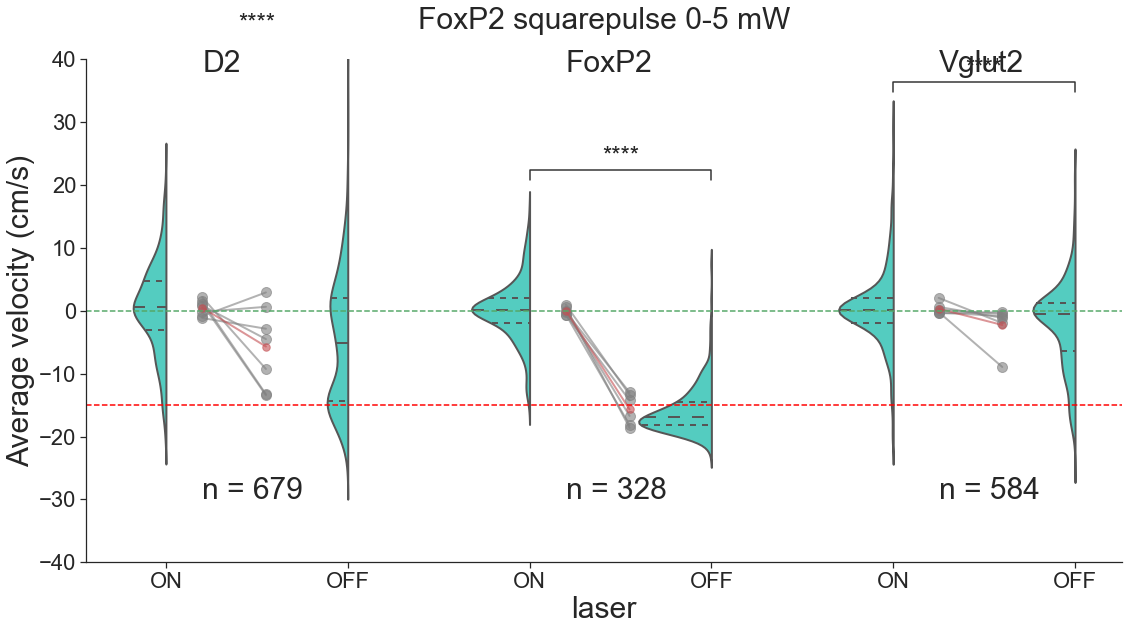

In [40]:
opto_par = 'ChR2'

stim_type = 'squarepulse_0-5_mW'
# stim_type = 'squarepulse_1_mW'


mouse_type_to_loc = {'D2' : 'STR', 'FoxP2': 'GPe', 'Vglut2': 'STN'}
stim_loc_list = list(mouse_type_to_loc .values())
subplot_parameter = 'mouse_type'

subplot_param_list = stim_loc_list
add_title = mouse_type + ' '
figname = '_'.join([mouse_type, opto_par, stim_loc, stim_type])


summary_files_list = get_all_filepaths_same_protocol(stim_loc_list, 
                                                     pre_direct, 
                                                     stim_type, 
                                                     opto_par)

n_files = len(summary_files_list)

mouse_types = [os.path.basename(f).split('_')[0] for f in summary_files_list]
stim_locs = [os.path.basename(f).split('_')[2] for f in summary_files_list]

summary_files_list = [summary_files_list[i] for i in range(n_files) if mouse_types[i] in mouse_type_to_loc and mouse_type_to_loc[mouse_types[i]] == stim_locs[i] ]
box_pairs, result, n_trials_dict, epochs_mean_mouse_dict = create_df_from_data_summary(summary_files_list, intervals_dict,
                                                                                  subplot_parameter = subplot_parameter,
                                                                                  opto_par = opto_par)


print(result.head())

sns.set(font_scale = 2)
sns.set_style("white")

g = sns.catplot(x = "epoch", y = "mean_velocity", 
                hue = "optogenetic expression", 
                data = result, kind = "violin",  palette = ['turquoise'],
                height = 5, scale_hue = False, linewidth = 2,
                inner = "quartile", split = True, scale = 'area',
                hue_order = ['ChR2','Control'], legend = False, gridsize = 100 )

ax = g.axes.flatten()[0]
add_stat_annotation(ax, data = result,
                    x = "epoch", y = "mean_velocity",
                    hue = "optogenetic expression",
                    box_pairs = box_pairs,
                    test='Wilcoxon', text_format='star', 
                    loc='inside', verbose=2)

x_series = [[0.2, 0.55], [2.2, 2.55], [4.25, 4.6]]#, [6.9, 7.25]]

ax = plot_individual_mice(ax, epochs_mean_mouse_dict, n_trials_dict, x_series, 
                         sub_title_y = 38, n_annotate_y = -30)

ax.axhline( y=0, ls='--', c='g')
ax.axhline( y=treadmill_velocity, ls='--', c='red')


(g.set_axis_labels("laser", "Average velocity (cm/s)", fontsize=30)
  .set_xticklabels(flatten([['ON', 'OFF'] *(len(box_pairs))]))
  .set(ylim = (-40, 40)))


ax.tick_params(direction='out')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_title(add_title + stim_type.replace('_', ' '), fontsize = 30,pad = 30)
g.fig.set_figwidth(25.0)
g.fig.set_figheight(10)

Directory.create_dir_if_not_exist(os.path.join(pre_direct, 'Subplots', 'Violin_plots' ))

fig = ax.get_figure()
save_pdf_png(fig, 
             os.path.join(pre_direct, 'Subplots','Violin_plots', figname ), 
             size = fig.get_size_inches()*fig.dpi)

In [22]:
mouse_type = 'D2'
ON_D2 = result_Ctr[(result_Ctr['mouse_type']==mouse_type) & (result_Ctr['epoch']=='ON')]['mean_velocity'] 
OFF_D2 = result_Ctr[(result_Ctr['mouse_type']==mouse_type) & (result_Ctr['epoch']=='OFF')]['mean_velocity'] 
print(ON_D2)
mouse_type = 'Vglut2'
ON_Vglut2 = result_Ctr[(result_Ctr['mouse_type']==mouse_type) & (result_Ctr['epoch']=='ON')]['mean_velocity'] 
OFF_Vglut2 = result_Ctr[(result_Ctr['mouse_type']==mouse_type) & (result_Ctr['epoch']=='OFF')]['mean_velocity'] 
print(ON_Vglut2)
mouse_type = 'FoxP2'
ON_FoxP2 = result_Ctr[(result_Ctr['mouse_type']==mouse_type) & (result_Ctr['epoch']=='ON')]['mean_velocity'] 
OFF_FoxP2 = result_Ctr[(result_Ctr['mouse_type']==mouse_type) & (result_Ctr['epoch']=='OFF')]['mean_velocity'] 
#df = pd.DataFrame(({'D2-ON':ON_D2.values,'D2-OFF':OFF_D2.values,'Vglut22-ON':ON_Vglut2.values,
#                    'Vglut22-OFF':OFF_Vglut2.values,'FoxP2-ON':ON_FoxP2.values,'FoxP2-OFF':OFF_FoxP2.values}))
df1 = pd.DataFrame(({'D2-ON':ON_D2.values,'D2-OFF':OFF_D2.values }))
df2 = pd.DataFrame(({'Vglut22-ON':ON_Vglut2.values,'Vglut22-OFF':OFF_Vglut2.values}))
df3 = pd.DataFrame(({'FoxP2-ON':ON_FoxP2.values,'FoxP2-OFF':OFF_FoxP2.values}))
datatoexcel = pd.ExcelWriter(pre_direct+'sum.xlsx',engine = 'xlsxwriter')
df1.to_excel(datatoexcel,sheet_name = 'Sheet1')
df2.to_excel(datatoexcel,sheet_name = 'Sheet2')
df3.to_excel(datatoexcel,sheet_name = 'Sheet3')
datatoexcel.save()
#df.to_csv(pre_direct+'sum.csv',index=False)

227    -0.940305
228    -5.136120
229    -2.639385
230    14.438407
231    18.438676
         ...    
449    -1.943511
450     1.807367
451     0.127015
452     0.072582
453     0.542743
Name: mean_velocity, Length: 227, dtype: float64
1058   -8.759184
1059   -5.606506
1060    2.044469
1061   -6.019322
1062   -9.405924
          ...   
1211    2.710242
1212   -6.115310
1213    0.687927
1214   -5.765207
1215   -3.643182
Name: mean_velocity, Length: 158, dtype: float64


## FIX ChR2 + Control one protocol 

D2_ChR2_Square_HI_1_mov_aver.npz
(748, 501)
D2_Control_Square_HI_1.npz
(228, 501)
FoxP2_ChR2_Square_HI_1_mov_aver.npz
(711, 501)
FoxP2_Control_Square_HI_1.npz
(223, 501)
Vglut_ChR2_Square_HI_1_mov_aver.npz
(778, 501)
Vglut_Control_Square_HI_1.npz
(158, 501)


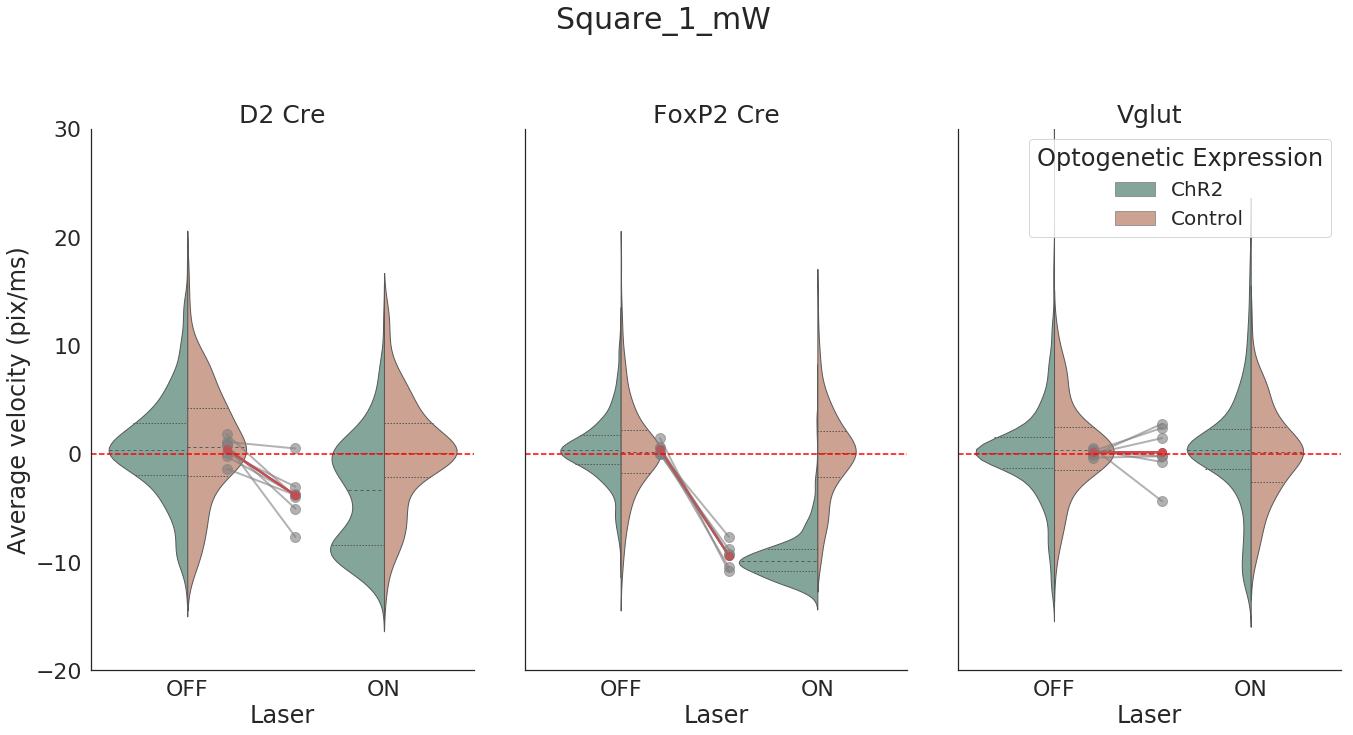

In [16]:

# path = "/Users/apple/Desktop/data_npz/"
folder = "Square_1_mW"
path = os.path.jion(pre_direct,'data_npz',folder)
extension_summary = ".npz"
Summary_files_list = list_all_files(path,extension_summary)
col_names =  ['mean_velocity', 'mouse_type', 'optogenetic expression', 'pulse_type','intensity_mW','epoch']
result = pd.DataFrame(columns = col_names)

# direct = pre_direct +mouse_type+'/'+opto_par+ '/Mouse_' +str(mouse_no)+ '/'  # directory to the folder for each mouse


for file in Summary_files_list:
    print(file)
    dat = npzfile = np.load(os.path.join(path,file))
    properties=file.split("_")
    epochs = dat[dat.files[0]]
    ## data for individual plot points of mice
    if properties[0]=='Vglut2' and properties[1] != 'Control':
        epochs_mean_mouse_Vglut2 = dat[dat.files[1]]
    if properties[0]=='D2'and properties[1] != 'Control':
        epochs_mean_mouse_D2 = dat[dat.files[1]]
    if properties[0]=='FoxP2'and properties[1] != 'Control':
        epochs_mean_mouse_FoxP2 = dat[dat.files[1]]
        
    pre = epochs[:,:pre_interval] ; post = epochs[:,pre_interval+1:pre_interval+interval+1]
    mouse_type_ = [properties[0]] * epochs.shape[0]*2
    opto_par_ = [properties[1]] * epochs.shape[0]*2
    pulse_ = [properties[2]] * epochs.shape[0]*2
#     intensity, data_type = properties[4].split('.')
    inten_ = [properties[4]] * epochs.shape[0]*2
    off_vel = np.average(pre,axis = 1)
    on_vel = np.average(post,axis = 1)
    all_ = np.concatenate((off_vel,on_vel),axis = 0)
    epoch_off = ['OFF'] * epochs.shape[0]
    epoch_on = ['ON'] * epochs.shape[0]
    epoch_ = epoch_off+epoch_on
    print(epochs.shape)
    df = pd.DataFrame(({'mean_velocity':all_, 
                        'mouse_type':mouse_type_, 'optogenetic expression':opto_par_, 'pulse_type':pulse_,
                        'intensity_mW':inten_,'epoch':epoch_}))
    frames = [result, df]
    result = pd.concat(frames,ignore_index=True)
result.head()

import seaborn as sns

sns.set_style("white")

g = sns.catplot(x="epoch", y="mean_velocity",
                hue="optogenetic expression", col="mouse_type",
                data=result, kind="violin", split=True, palette = sns.color_palette("Set2", n_colors=2, desat=.5),
                height=5, scale_hue=False, linewidth = 1, inner="quartile", scale = 'area',
                hue_order=['ChR2','Control'],col_order=['D2','FoxP2','Vglut2'],legend = False)
x_series = [0.2,0.55]
ax1, ax2, ax3 = g.axes[0]
for i in range (epochs_mean_mouse_Vglut2.shape[0]):
    ax3.plot(x_series,epochs_mean_mouse_Vglut2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax3.plot(x_series,np.average(epochs_mean_mouse_Vglut2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

for i in range (epochs_mean_mouse_D2.shape[0]):
    ax1.plot(x_series,epochs_mean_mouse_D2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax1.plot(x_series,np.average(epochs_mean_mouse_D2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

for i in range (epochs_mean_mouse_FoxP2.shape[0]):
    ax2.plot(x_series,epochs_mean_mouse_FoxP2[i,:2],'-',color = 'gray',marker = 'o',markersize=10,linewidth=2,alpha=0.6)
    ax2.plot(x_series,np.average(epochs_mean_mouse_FoxP2[:,:2],axis =0),'-',color = 'r',marker = '.',markersize=15,linewidth=2,alpha=0.6)

sns.set(font_scale = 2)
sns.set_style("white")
plt.ylim([-20,30])
# plt.xlim([-2,2])
ax1, ax2, ax3 = g.axes[0]
ax1.axhline( y=0, ls='--', c='red')
ax2.axhline( y=0, ls='--', c='red')
ax3.axhline( y=0, ls='--', c='red')
ax1.set_title('D2 Cre', y=0.95, fontsize = 25)
ax2.set_title('FoxP2 Cre', y=0.95, fontsize = 25)
ax3.set_title('Vglut2', y=0.95, fontsize = 25)
g.set_axis_labels("Laser", "Average velocity (pix/ms)")
plt.suptitle(folder,fontsize= 30,y = 1)
g.fig.set_figwidth(20.0)
g.fig.set_figheight(12)
legend = plt.legend(loc='upper right', title='Optogenetic Expression',fontsize= 20)
plt.savefig(os.path.join(path,folder+'.pdf'),bbox_inches='tight',orientation='landscape',dpi=350)



## Different intensities of one mouse line

### Beta Pulse

/media/shiva/LaCie/Data_INCIA_Shiva_sorted/data_npz/STR/betapulse_5_mW/ChR2/Vglut2D2_ChR2_STR_betapulse_5_mW_mov_aver_window=40_V_window=120ms_x_velocity_Tail_Nose.npz ['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice', 'avg_pre_stim_position', 'avg_pre_stim_velocity', 'avg_pre_stim_acc', 'cor', 'body_part', 'plot_param']
shapiro : ShapiroResult(statistic=0.9833481907844543, pvalue=0.018144475296139717)
MW stat_result: MannwhitneyuResult(statistic=22317.0, pvalue=0.04510811731109546)
Wilcoxon stat_result: WilcoxonResult(statistic=7431.0, pvalue=0.0013952798612210638)
OFF 0.5970826175709275 0.4400259866438812
ON -1.705830858400684 0.5213478670980056
n_trials: (200, 501)
/media/shiva/LaCie/Data_INCIA_Shiva_sorted/data_npz/STR/betapulse_2-5_mW/ChR2/Vglut2D2_ChR2_STR_betapulse_2-5_mW_mov_aver_window=40_V_window=120ms_x_velocity_Tail_Nose.npz ['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice', 'avg_pre_stim_position', 'avg_pre_stim_velocity', 'avg_pre_s

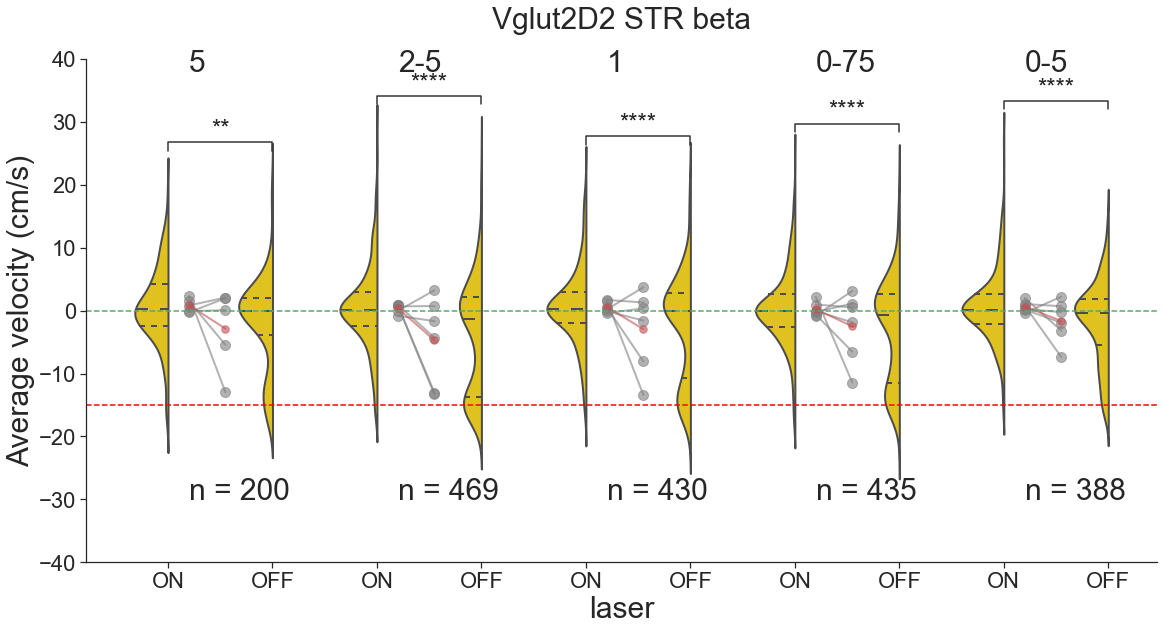

In [34]:
opto_par = 'ChR2'
mouse_type = 'Vglut2D2'
stim_loc = 'STR'

# opto_par = 'ChR2'
# mouse_type = 'FoxP2'
# stim_loc = 'GPe'

# opto_par = 'ChR2'
# mouse_type = 'Vglut2'
# stim_loc = 'STN'

# opto_par = 'ChR2'
# mouse_type = 'D2'
# stim_loc = 'STR'

pulse = 'beta'

summary_files_list = get_all_filepaths_different_intensities( pre_direct, pulse = pulse, 
                                                             opto_par = opto_par, stim_loc = stim_loc, mouse_type = mouse_type)


subplot_parameter = 'intensity'

title = mouse_type + ' ' + stim_loc + ' ' + pulse
figname = '_'.join([mouse_type, opto_par, stim_loc, pulse])



box_pairs, result, n_trials_dict, epochs_mean_mouse_dict = create_df_from_data_summary(summary_files_list, intervals_dict,
                                                                                       subplot_parameter = subplot_parameter,
                                                                                       opto_par = opto_par)


print(result.head())

sns.set(font_scale = 2)
sns.set_style("white")

g = sns.catplot(x = "epoch", y = "mean_velocity", 
                hue = "optogenetic expression", 
                data = result, kind = "violin",  palette = ["gold"],
                height = 5, scale_hue = False, linewidth = 2,
                inner = "quartile", split = True, scale = 'area',
                hue_order = ['ChR2','Control'], legend = False, gridsize = 100 )

ax = g.axes.flatten()[0]
add_stat_annotation(ax, data = result,
                    x = "epoch", y = "mean_velocity",
                    hue = "optogenetic expression",
                    box_pairs = box_pairs,
                    test='Wilcoxon', text_format='star', 
                    loc='inside', verbose=2)

x_series = [[0.2 + 2 *i, 0.55 + 2 * i] for i in range(len(summary_files_list))]

ax = plot_individual_mice(ax, epochs_mean_mouse_dict, n_trials_dict, x_series, 
                         sub_title_y = 38, n_annotate_y = -30)

ax.axhline( y=0, ls='--', c='g')
ax.axhline( y=treadmill_velocity, ls='--', c='red')


(g.set_axis_labels("laser", "Average velocity (cm/s)", fontsize=30)
  .set_xticklabels(flatten([['ON', 'OFF'] *(len(box_pairs))]))
  .set(ylim = (-40, 40)))


ax.tick_params(direction='out')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_title(title, fontsize = 30,pad = 30)
g.fig.set_figwidth(25.0)
g.fig.set_figheight(10)

Directory.create_dir_if_not_exist(os.path.join(pre_direct, 'Subplots', 'Violin_plots' ))


fig = ax.get_figure()
save_pdf_png(fig, 
             os.path.join(pre_direct, 'Subplots','Violin_plots', figname ), 
             size = fig.get_size_inches()*fig.dpi)

### Square Pulse

/media/shiva/LaCie/Data_INCIA_Shiva_sorted/data_npz/GPe/Two_intensities/FoxP2_ChR2_GPe_squarepulse_0-25_mW_mov_aver_window=40_V_window=120ms_x_velocity_Tail_Nose.npz ['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice', 'avg_pre_stim_position', 'avg_pre_stim_velocity', 'avg_pre_stim_acc', 'cor', 'body_part', 'plot_param']
shapiro : ShapiroResult(statistic=0.8820418119430542, pvalue=3.6388920305815975e-13)
MW stat_result: MannwhitneyuResult(statistic=64245.0, pvalue=4.533221792790155e-81)
Wilcoxon stat_result: WilcoxonResult(statistic=329.0, pvalue=6.566354609078481e-42)
OFF -0.07914460278584994 0.2830205578586539
ON -15.567171301174882 0.22793369987416717
n_trials: (255, 501)
/media/shiva/LaCie/Data_INCIA_Shiva_sorted/data_npz/GPe/Two_intensities/FoxP2_ChR2_GPe_squarepulse_1_mW_mov_aver_window=40_V_window=120ms_x_velocity_Tail_Nose.npz ['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice', 'avg_pre_stim_position', 'avg_pre_stim_velocity', 'avg_pre_stim_

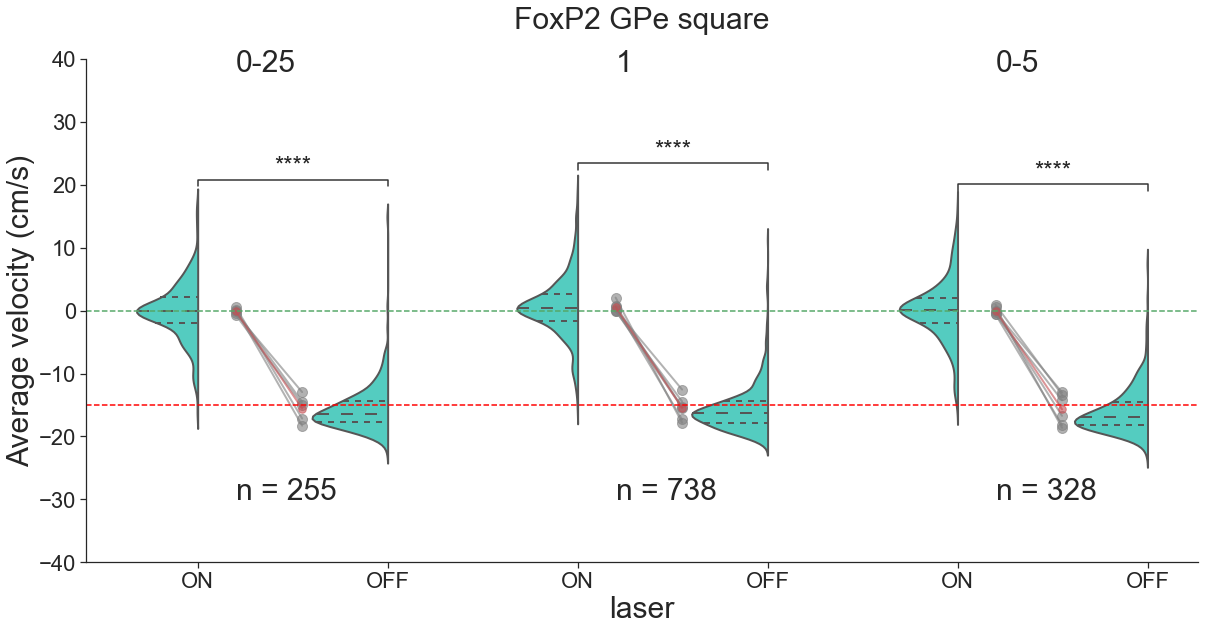

In [38]:
opto_par = 'ChR2'
mouse_type = 'FoxP2'
stim_loc = 'GPe'

# opto_par = 'ChR2'
# mouse_type = 'Vglut2D2'
# stim_loc = 'STR'

# opto_par = 'ChR2'
# mouse_type = 'Vglut2'
# stim_loc = 'STN'

# opto_par = 'ChR2'
# mouse_type = 'D2'
# stim_loc = 'STR'


pulse = 'square'
subplot_parameter = 'intensity'

summary_files_list = get_all_filepaths_different_intensities( pre_direct, pulse = pulse, 
                                                             opto_par = opto_par, 
                                                             stim_loc = stim_loc, 
                                                             mouse_type = mouse_type)



title = mouse_type + ' ' + stim_loc + ' ' + pulse
figname = '_'.join([mouse_type, opto_par, stim_loc, pulse])



box_pairs, result, n_trials_dict, epochs_mean_mouse_dict = create_df_from_data_summary(summary_files_list, intervals_dict,
                                                                                       subplot_parameter = subplot_parameter,
                                                                                       opto_par = opto_par)


print(result.head())

sns.set(font_scale = 2)
sns.set_style("white")

g = sns.catplot(x = "epoch", y = "mean_velocity", 
                hue = "optogenetic expression", 
                data = result, kind = "violin",  palette = ["turquoise"],
                height = 5, scale_hue = False, linewidth = 2,
                inner = "quartile", split = True, scale = 'area',
                hue_order = ['ChR2','Control'], legend = False, gridsize = 100 )

ax = g.axes.flatten()[0]
add_stat_annotation(ax, data = result,
                    x = "epoch", y = "mean_velocity",
                    hue = "optogenetic expression",
                    box_pairs = box_pairs,
                    test='Wilcoxon', text_format='star', 
                    loc='inside', verbose=2)

x_series = [[0.2 + 2 *i, 0.55 + 2 * i] for i in range(len(summary_files_list))]

ax = plot_individual_mice(ax, epochs_mean_mouse_dict, n_trials_dict, x_series, 
                         sub_title_y = 38, n_annotate_y = -30)

ax.axhline( y=0, ls='--', c='g')
ax.axhline( y=treadmill_velocity, ls='--', c='red')


(g.set_axis_labels("laser", "Average velocity (cm/s)", fontsize=30)
  .set_xticklabels(flatten([['ON', 'OFF'] *(len(box_pairs))]))
  .set(ylim = (-40, 40)))


ax.tick_params(direction='out')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_title(title, fontsize = 30,pad = 30)
g.fig.set_figwidth(25.0)
g.fig.set_figheight(10)

Directory.create_dir_if_not_exist(os.path.join(pre_direct, 'Subplots', 'Violin_plots' ))

fig = ax.get_figure()
save_pdf_png(fig, 
             os.path.join(pre_direct, 'Subplots','Violin_plots', figname ), 
             size = fig.get_size_inches()*fig.dpi)

# $\Delta V$ vs. laser intensity all mouse lines

/media/shiva/LaCie/Data_INCIA_Shiva_sorted/data_npz/STR/squarepulse_1_mW/ChR2/Vglut2D2_ChR2_STR_squarepulse_1_mW_mov_aver_window=40_V_window=120ms_x_velocity_Tail_Nose.npz ['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice', 'avg_pre_stim_position', 'avg_pre_stim_velocity', 'avg_pre_stim_acc', 'cor', 'body_part', 'plot_param']
shapiro : ShapiroResult(statistic=0.9792305827140808, pvalue=0.1275322437286377)
MW stat_result: MannwhitneyuResult(statistic=6992.0, pvalue=4.950928378843828e-09)
Wilcoxon stat_result: WilcoxonResult(statistic=521.0, pvalue=2.446771831308994e-11)
OFF 0.5217670602890079 0.746516805580679
ON -6.979306699924128 0.8161961442767681
n_trials: (97, 501)
/media/shiva/LaCie/Data_INCIA_Shiva_sorted/data_npz/STR/squarepulse_0-5_mW/ChR2/Vglut2D2_ChR2_STR_squarepulse_0-5_mW_mov_aver_window=40_V_window=120ms_x_velocity_Tail_Nose.npz ['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice', 'avg_pre_stim_position', 'avg_pre_stim_velocity', 'avg_p

/media/shiva/LaCie/Data_INCIA_Shiva_sorted/data_npz/STN/squarepulse_1_mW/ChR2/Vglut2_ChR2_STN_squarepulse_1_mW_mov_aver_window=40_V_window=120ms_x_velocity_Tail_Nose.npz ['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice', 'avg_pre_stim_position', 'avg_pre_stim_velocity', 'avg_pre_stim_acc', 'cor', 'body_part', 'plot_param']
shapiro : ShapiroResult(statistic=0.9497032761573792, pvalue=8.50878000378802e-16)
MW stat_result: MannwhitneyuResult(statistic=291278.0, pvalue=0.011146321988162419)
Wilcoxon stat_result: WilcoxonResult(statistic=153015.0, pvalue=0.49574102057781577)
OFF 0.05684891256369932 0.24269464825226028
ON 0.40001127696117006 0.29544481712133536
n_trials: (793, 501)
/media/shiva/LaCie/Data_INCIA_Shiva_sorted/data_npz/STN/squarepulse_0-5_mW/ChR2/Vglut2_ChR2_STN_squarepulse_0-5_mW_mov_aver_window=40_V_window=120ms_x_velocity_Tail_Nose.npz ['epochs_all_mice', 'epochs_mean_each_mouse', 'epochs_spont_all_mice', 'avg_pre_stim_position', 'avg_pre_stim_velocity', 

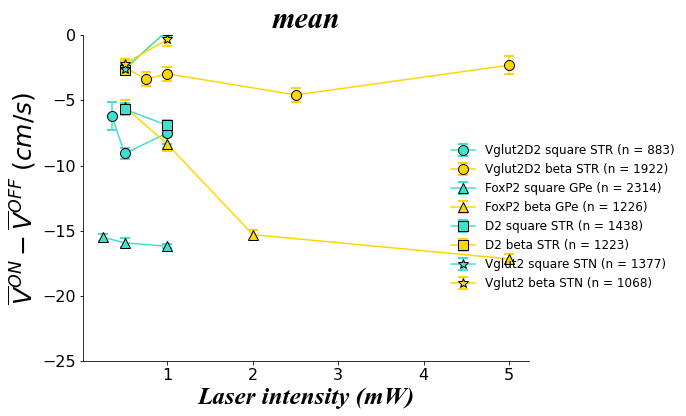

In [4]:
opto_par = 'ChR2'
mouse_type = 'Vglut2D2'
stim_loc = 'STR'
pulse = 'beta'

measure = 'min'
measure = 'mean'
ylim = (-25, 0)
experiment_dict = {'mouse_type': ['Vglut2D2', 'Vglut2D2', 'FoxP2', 'FoxP2', 'D2', 'D2', 'Vglut2', 'Vglut2'],
                   'opto_par': ['ChR2'] * 8,
                   'stim_loc': ['STR', 'STR', 'GPe', 'GPe', 'STR', 'STR', 'STN', 'STN'],
                   'pulse': ['square', 'beta', 'square', 'beta', 'square', 'beta', 'square', 'beta'],
                   'marker': ['o', 'o', '^', '^', 's', 's', '*', '*'],
                   'color': ['turquoise', 'gold', 'turquoise', 'gold','turquoise', 'gold','turquoise', 'gold']}


n_exp = len(experiment_dict['pulse'])
fig, ax = plt.subplots(figsize = (8,6))

ylabel = {'mean': r'$\overline{V}^{ON} - \overline{V}^{OFF} \; (cm/s)$',
          'min': r'${V}_{min}^{ON} - \overline{V}^{OFF} \; (cm/s)$'}
for i in range(n_exp):

    intensity, mean_dv, std_dv, n_trials = delta_v_vs_laser_intensity(pre_direct, intervals_dict,
                                                            opto_par = experiment_dict['opto_par'][i],
                                                            stim_loc = experiment_dict['stim_loc'][i],
                                                            mouse_type = experiment_dict['mouse_type'][i],
                                                            pulse = experiment_dict['pulse'][i],
                                                           measure = measure)
    
    ax.errorbar(intensity, mean_dv, std_dv,
                marker = experiment_dict['marker'][i], 
                color =  experiment_dict['color'][i], 
                ms = 10, mec = 'k',
                capsize = 5, capthick = 2, 
                label = ' '.join([experiment_dict['mouse_type'][i], 
                                  experiment_dict['pulse'][i],
                                  experiment_dict['stim_loc'][i]]) \
                                  # experiment_dict['opto_par'][i]]) \
                        + ' (n = ' + str(n_trials) + ')'
                )
    remove_frame(ax)
    ax.set_xlabel('Laser intensity (mW)').set_fontproperties(font_label)
    ax.set_ylabel(ylabel[measure]).set_fontproperties(font_label)
    ax.legend(fontsize = 12, frameon = False,  loc = 'upper left', bbox_to_anchor=(.8, 0.7))

ax.set_ylim(ylim)
ax.set_title(measure).set_fontproperties(font)
Directory.create_dir_if_not_exist(os.path.join(pre_direct, 'Subplots', 'Square_vs_beta'))
ax.tick_params(axis='both', which='major', labelsize = 16)

figname = 'Square_vs_Beta_' + measure + '_velocity_' + '_'.join(np.unique(experiment_dict['mouse_type']))
save_pdf_png(fig, 
             os.path.join(pre_direct, 'Subplots','Square_vs_beta', figname ), 
             size = fig.get_size_inches()*fig.dpi)


# Plot the Pre Laser X Distribution

mouse #  8
session 1 out of 2
Looking at --- Tail ---
# inconsistent right left =  1
# jitter in mean(righ,left)  =  706
Looking at --- Nose ---
# inconsistent right left =  7
# jitter in mean(righ,left)  =  1769
0  trials discarded
session 2 out of 2
Looking at --- Tail ---
# inconsistent right left =  0
# jitter in mean(righ,left)  =  501
Looking at --- Nose ---
# inconsistent right left =  0
# jitter in mean(righ,left)  =  1599
0  trials discarded
mouse #  9
session 1 out of 2
Looking at --- Tail ---
# inconsistent right left =  0
# jitter in mean(righ,left)  =  661
Looking at --- Nose ---
# inconsistent right left =  0
# jitter in mean(righ,left)  =  1482
0  trials discarded
session 2 out of 2
Looking at --- Tail ---
# inconsistent right left =  0
# jitter in mean(righ,left)  =  723
Looking at --- Nose ---
# inconsistent right left =  7
# jitter in mean(righ,left)  =  1903
0  trials discarded
mouse #  10
session 1 out of 2
Looking at --- Tail ---
# inconsistent right left =  2
# ji

<Figure size 432x288 with 0 Axes>

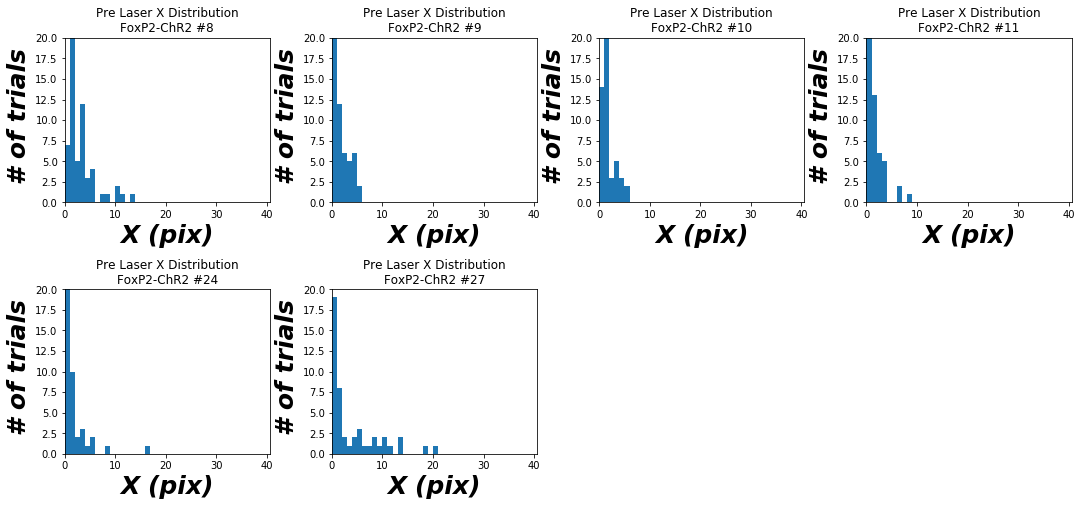

In [12]:
opto_par = 'ChR2'
folder = 'Square_0-5_mW'

mouse_type = 'FoxP2'
folder_spont = 'Spontaneous'

pre_stim_inter = 60 # number of timebins in the pre-stimulus period 
# n_bins = 45
plt.figure(2)
fig = plt.figure(figsize=(15,10))
count = 0
min_x = 0*scale_pix_to_cm
max_y = 20 ; max_x = right_edge_x*scale_pix_to_cm
step = 1
bins_list = np.arange(0,max_x,step)
for n in mouse_no_dict[mouse_type][0]: # Run over all the mice
    count +=1
    start = timeit.default_timer()
    mouse_no = n
    print('mouse # ',n)
    direct = os.path.join(pre_direct, mouse_type, opto_par, 'Mouse_' +str(mouse_no)) # directory to the folder for each mouse

    files_list_DLC = list_all_files(os.path.join(direct,folder,'DLC'),'.xlsx')
    files_list_Laser = list_all_files(os.path.join(direct,folder,'Laser'),'.xlsx')

    pre_x_position_epochs = extract_pre_laser_x_epochs_over_trials(files_list_DLC,files_list_Laser,
                                           direct,folder,scale_pix_to_cm,t_window_dict['window_pos'],misdetection_dict,
                                           *accep_interval_range,pre_stim_inter)
    pre_x_position = np.average(pre_x_position_epochs,axis = 1)
    
    x = fig.add_subplot(3,4,count)
    
    plt.hist(pre_x_position, bins=bins_list)
    plt.ylabel(" # of trials", fontproperties=font_label)
    plt.xlabel("X (pix)", fontproperties=font_label)
    plt.xlim(min_x,max_x) #set limits
    plt.ylim(0,max_y) #set limits
    plt.title("Pre Laser X Distribution"+"\n"+mouse_type+'-'+opto_par+' #'+str(mouse_no))

plt.tight_layout()
plt.savefig(os.path.join(pre_direct,'Subplots','Pre_laser_X_distribution_'+folder+"_"+opto_par+'_'+mouse_type+'_' +
            '.png'),bbox_inches='tight',orientation='landscape',dpi=400)
plt.show()




# Plot one animal's averege trials

Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1
 1. Position 
 2. Velocity 
 
2
session 1 out of 5
Looking at --- Tail ---
# inconsistent right left =  0
# jitter in mean(righ,left)  =  223
Looking at --- Nose ---
# inconsistent right left =  0
# jitter in mean(righ,left)  =  756
0  trials discarded
session 2 out of 5
Looking at --- Tail ---
# inconsistent right left =  12
# jitter in mean(righ,left)  =  563
Looking at --- Nose ---
# inconsistent right left =  4
# jitter in mean(righ,left)  =  1297
0  trials discarded
session 3 out of 5
Looking at --- Tail ---
There's a shift between left and right detections. Don't worry we will fix it!
# inconsistent right left =  1
# jitter in mean(righ,left)  =  185
Looking at --- Nose ---
There's a shift between left and right detections. Don't worry we will fix it!
# inconsistent right left =  10
# jitter in mean(righ,left)  =  713
0  trials discarded
session 4 out of 

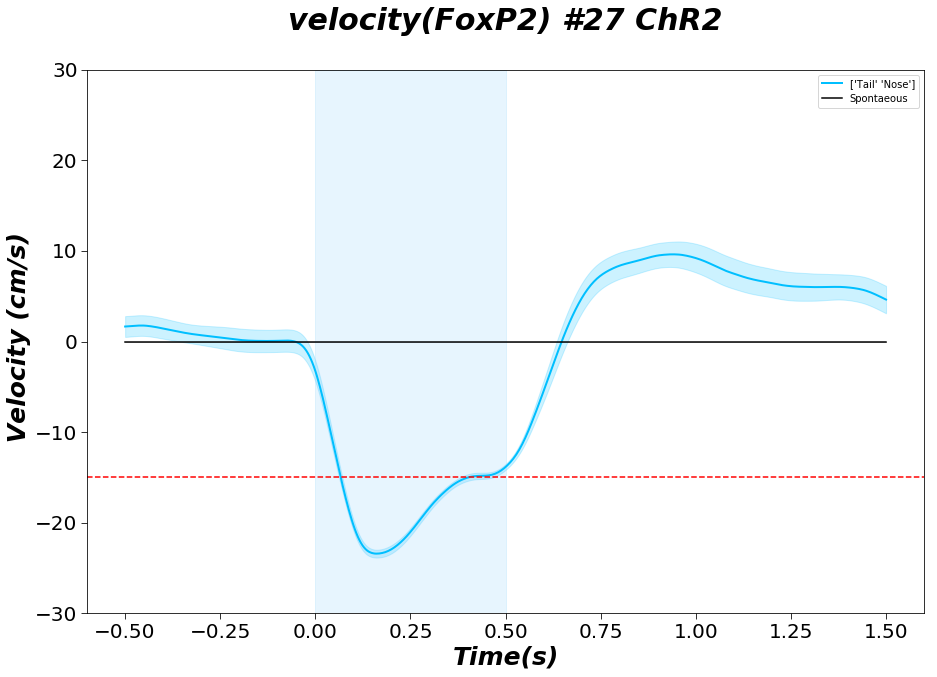

In [14]:
study_param_dict = get_input_cor_body_part(**exp_dict) # decide to average over what and which coordinates

mouse_type= 'FoxP2';opto_par = "ChR2"; mouse_no = 8; folder = "Square_1_mW"

if study_param_dict['plot_param'] == 'position':
    ylim = [-20,2]
elif study_param_dict['plot_param'] == 'velocity' :
    ylim = [-30,30]
    
direct = os.path.join(pre_direct, mouse_type, opto_par, 'Mouse_' +str(mouse_no)) # directory to the folder for each mouse

files_list_DLC = list_all_files(os.path.join(direct,folder,'DLC'),'.xlsx')
files_list_Laser = list_all_files(os.path.join(direct,folder,'Laser'),'.xlsx')
files_list_spont = list_all_files(os.path.join(direct,'Spontaneous','DLC'),'.xlsx')

#One session
# epochs = extract_epochs_over_trials([files_list_DLC[0]],[files_list_Laser[0]],direct,folder,spont)

# All sessions 
epochs,pre_info = extract_epochs_over_trials(files_list_DLC,files_list_Laser,direct,folder,scale_pix_to_cm,'n',accep_interval_range,
                                    spont_trial_dict,misdetection_dict,study_param_dict,**intervals_dict,**t_window_dict)
n_epochs = epochs.shape[0]
#epochs_spont, = extract_epochs_over_trials(files_list_spont,files_list_Laser,direct,'Spontaneous',scale_pix_to_cm,'y',accep_interval_range,
#                                spont_trial_dict,misdetection_dict,study_param_dict,**intervals_dict,**t_window_dict, no_sample = no_sample

epochs_spont = np.zeros(np.shape(epochs))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
# plot_pre_on_post(epochs[13,:],epochs_spont[10,:],average = 'n')
plot_pre_on_post(ax,pre_direct,mouse_type,opto_par,folder,epochs,epochs_spont,treadmill_velocity,ylim,**t_window_dict,**study_param_dict,
                             **intervals_dict,average = 'n',
                             c_laser = 'deepskyblue',c_spont = 'k',save_as_format = '.pdf')


# Plot one laser stimulation

Select for which parts you want to see the pre/On/post: 

 1. Tail 
 2. Nose 
 3. Fore Limb 
 4. Hind Limb
1 2
 1. X 
 2. Y 
1
 1. Position 
 2. Velocity 
 
2
['MouseFoxP2Cre_#8_SquarePulse_1mW_b18_DLC.xlsx', 'MouseFoxP2Cre_#8_SquarePulse_1mW_d02_DLC.xlsx', 'MouseFoxP2Cre_8-Square1mW-Bis-DLC.xlsx', 'MouseFoxP2Cre_8-Square1mW-DLC.xlsx', 'MouseFoxP2Cre_8-Square1mW_a15_DLC.xlsx']
session 1 out of 1
Looking at --- Tail ---
# inconsistent right left =  12
# jitter in mean(righ,left)  =  563
Looking at --- Nose ---
# inconsistent right left =  4
# jitter in mean(righ,left)  =  1297
0  trials discarded


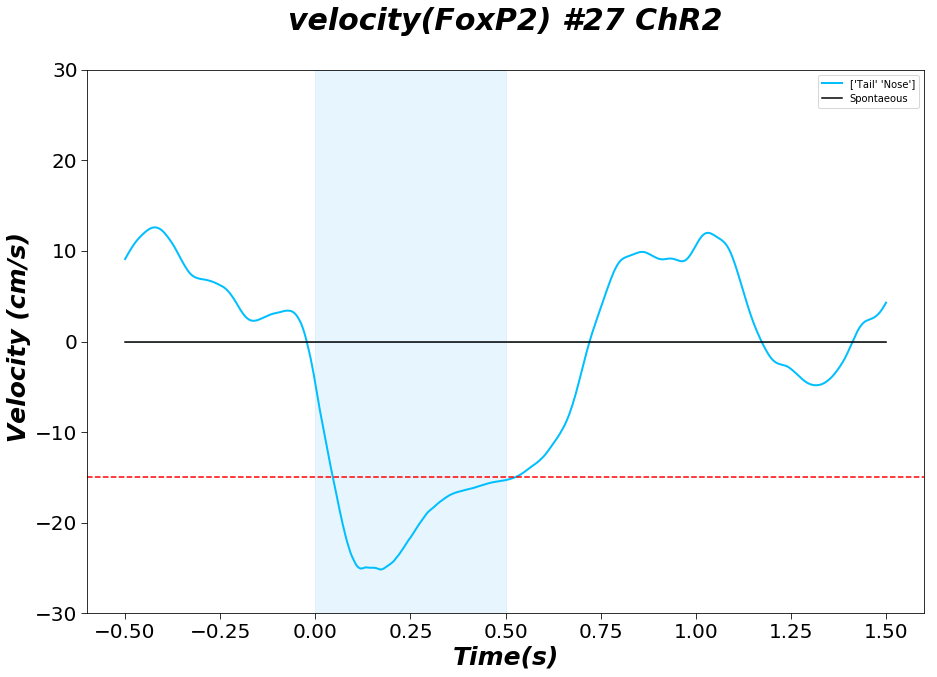

In [18]:
study_param_dict = get_input_cor_body_part(**exp_dict) # decide to average over what and which coordinates

j = 1 # number of trial in sessions
i = 1 #number of selected session in the list
mouse_type= 'FoxP2';opto_par = "ChR2"; mouse_no = 8; folder = "Square_1_mW"

if study_param_dict['plot_param'] == 'position':
    ylim = [-20,2]
elif study_param_dict['plot_param'] == 'velocity' :
    ylim = [-30,30]
    
direct = os.path.join(pre_direct, mouse_type, opto_par, 'Mouse_' +str(mouse_no)) # directory to the folder for each mouse

files_list_DLC = list_all_files(os.path.join(direct,folder,'DLC'),'.xlsx')
print(files_list_DLC)
files_list_Laser = list_all_files(os.path.join(direct,folder,'Laser'),'.xlsx')
files_list_spont = list_all_files(os.path.join(direct,'Spontaneous','DLC'),'.xlsx')


# All sessions 
epochs,pre_info = extract_epochs_over_trials([files_list_DLC[i]],[files_list_Laser[i]],direct,folder,scale_pix_to_cm,'n',accep_interval_range,
                                    spont_trial_dict,misdetection_dict,study_param_dict,**intervals_dict,**t_window_dict)
n_epochs = epochs.shape[0]
#epochs_spont, = extract_epochs_over_trials(files_list_spont,files_list_Laser,direct,'Spontaneous',scale_pix_to_cm,'y',accep_interval_range,
#                                spont_trial_dict,misdetection_dict,study_param_dict,**intervals_dict,**t_window_dict, no_sample = no_sample
selected_epoch = epochs[j,:]
epochs_spont = np.zeros(np.shape(selected_epoch))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharey=True)
# plot_pre_on_post(epochs[13,:],epochs_spont[10,:],average = 'n')
plot_pre_on_post(ax,pre_direct,mouse_type,opto_par,folder,selected_epoch,epochs_spont,treadmill_velocity,ylim,**t_window_dict,**study_param_dict,
                             **intervals_dict,average = 'n',
                             c_laser = 'deepskyblue',c_spont = 'k',save_as_format = '.pdf')


# Clean out data and match laser and DLC filenames

In [ ]:
path = '/media/shiva/LaCie/Data_INCIA_Shiva_sorted/FoxP2/Control/Mouse_26'
move_unwanter_files_out_of_folder(path)
directory = Directory(path)
directory.remove_spaces_dots()
get_sorted_laser_DLC_files(path)
rename_laser_files_according_to_DLC(path)

In [ ]:
path = '/media/shiva/LaCie/Data_INCIA_Shiva_sorted/FoxP2/Control/Mouse_26'
convert_all_xlsx_to_csv(path)

In [ ]:
path = '/media/shiva/LaCie/Data_INCIA_Shiva_sorted/FoxP2'            
unify_protocol_names(path)

# Video dynamic point plot for DLC demo

In [ ]:
df = pd.read_csv('/media/shiva/LaCie/interesting mouse trials/Mouse_8/MouseFoxP2Cre_#8_SquarePulse_0-25mW_g02_RightDLC_resnet50_Locomotion_Shiva_Mouse_8Jun22shuffle1_250000.csv',header=[1,2])
x = (df['RTail','x'].values+df['RNose','x'].values)*scale_pix_to_cm
start = 2900 ;  stop = 4200
x = x[start:stop]
time_series = np.arange(start,stop)/250
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), sharey=True)
ax.get_xaxis().set_tick_params(direction='out',labelsize = 10)
ax.xaxis.set_ticks_position('bottom')
ax.get_yaxis().set_tick_params(direction='out',labelsize = 10)
ax.yaxis.set_ticks_position('left')
plt.xlim(min(time_series),max(time_series))
plt.ylim(min(x),max(x))

for i in range(0,stop-start):
    if i%20 == 0:
        print(i)
    plt.plot(time_series[:i], x[:i], '-o', markersize = 5, lw = 1,c = 'darkslategrey')
    plt.ylabel(" Position (cm)",fontsize = 18)
    plt.xlabel(" Time (s)",fontsize = 18)
    plt.savefig('/home/shiva/Desktop/tracking/frame'+str(i).zfill(5)+'.png',bbox_inches='tight',orientation='landscape',dpi=300)